# Notebook setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

# Data reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            T_to_remove_list=[12], skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data",
                            operator_folder= "../operator_database",
                            max_n=3)


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Ratio Plot - Attempt 1

## Operator selection

In [3]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [4]:
"V"
(opV1*6).O
(opV2*np.sqrt(2)).O
(opV3*np.sqrt(2)).O
"A"
(opA1*np.sqrt(2)).O
(opA2*np.sqrt(2)).O
"T"
opT1.O
opT2.O
opT3.O
opT4.O

'V'

1.0*O[1, 1] + 1.0*O[2, 2] + 1.0*O[3, 3] - 3.0*O[4, 4]

1.0*O[3, 3] - 1.0*O[4, 4]

1.0*O[1, 4] + 1.0*O[4, 1]

'A'

1.0*O[1, 3] + 1.0*O[3, 1]

1.0*O[3, 4] + 1.0*O[4, 3]

'T'

1.0*O[2, 1, 1] - 1.0*O[2, 4, 4]

1.0*O[2, 3, 3] - 1.0*O[2, 4, 4]

1.0*O[1, 2, 4] - 1.0*O[2, 4, 1]

1.0*O[1, 4, 2] - 2.0*O[2, 1, 4] + 1.0*O[4, 2, 1]

In [5]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

opAnalyzer.selected_op

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[1, 4]/1000000000000000 + 707106781186547*O[4, 1]/1000000000000000,
 707106781186547*O[1, 3]/1000000000000000 + 707106781186547*O[3, 1]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[2, 1, 1] - O[2, 4, 4],
 O[2, 3, 3] - O[2, 4, 4],
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

## Ratios

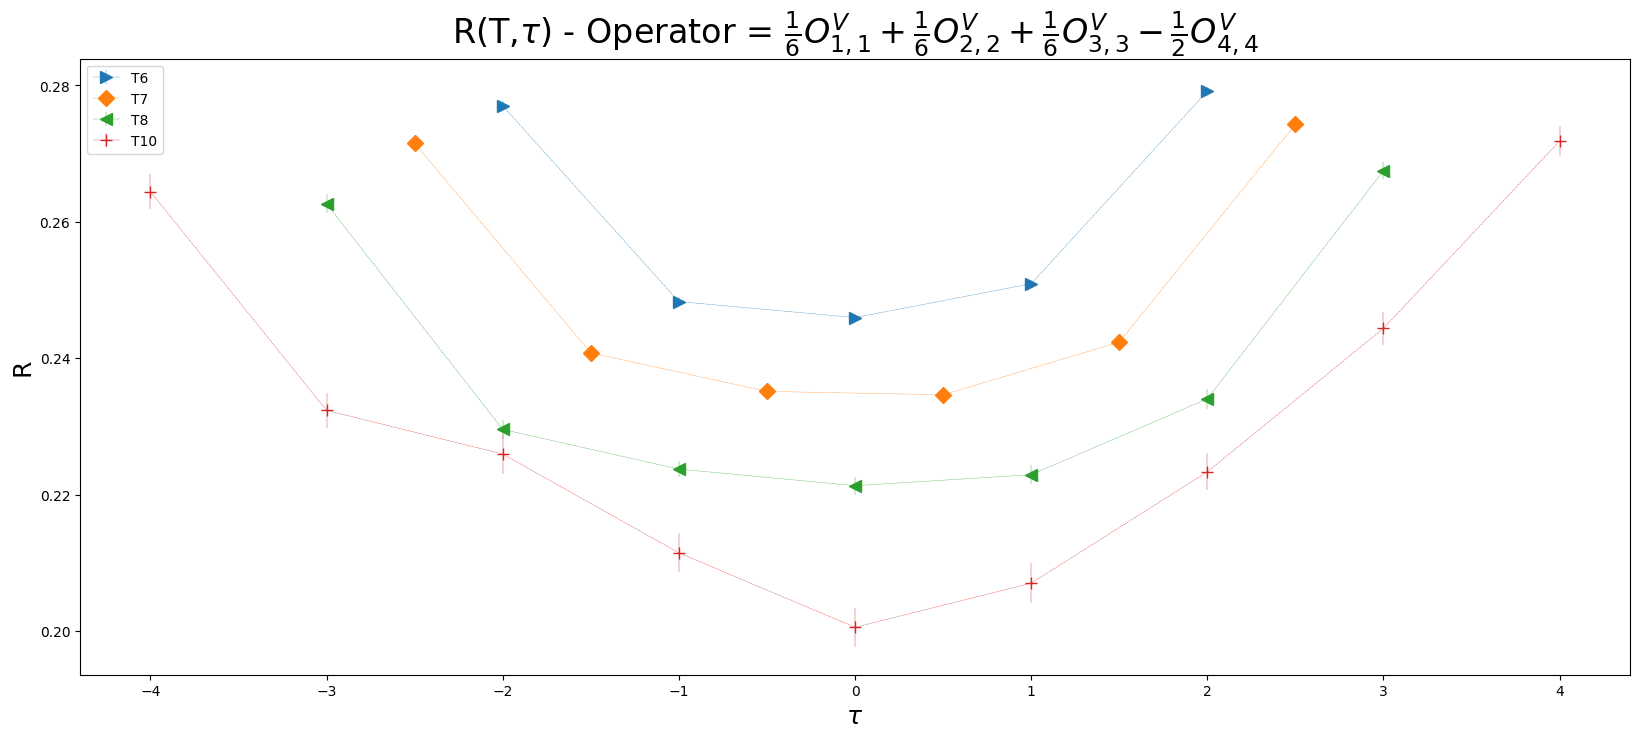

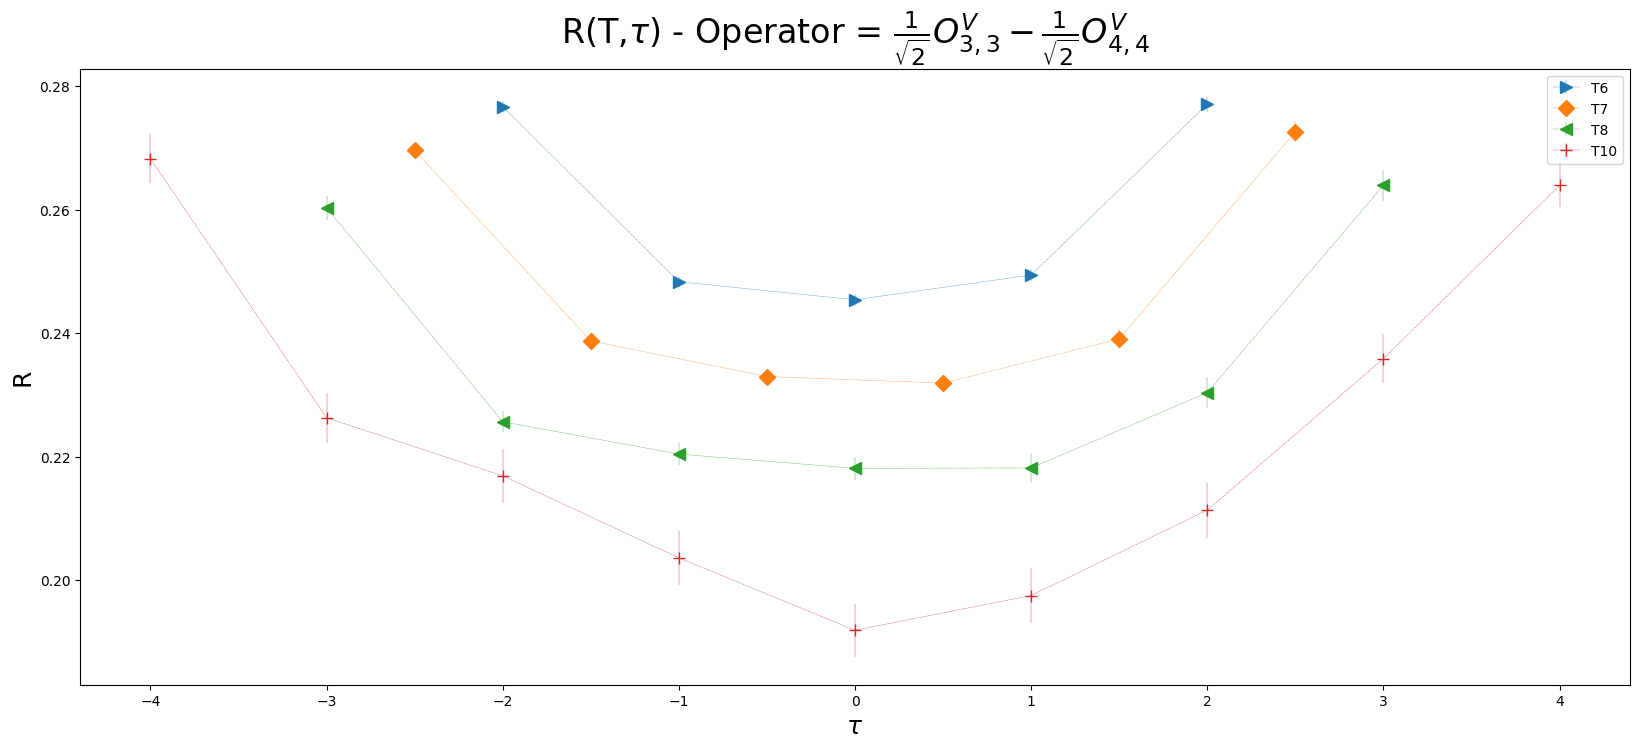

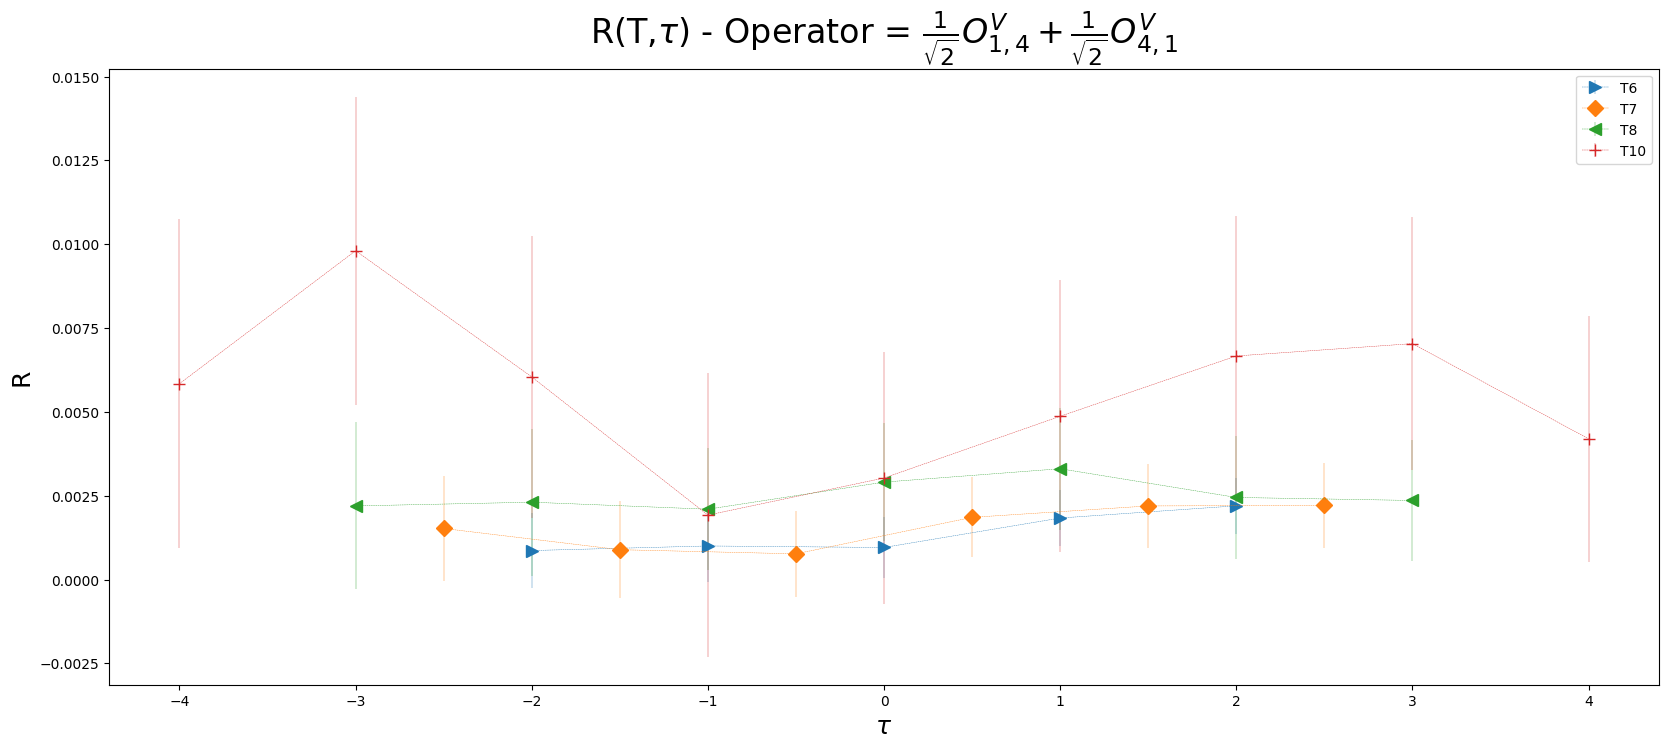

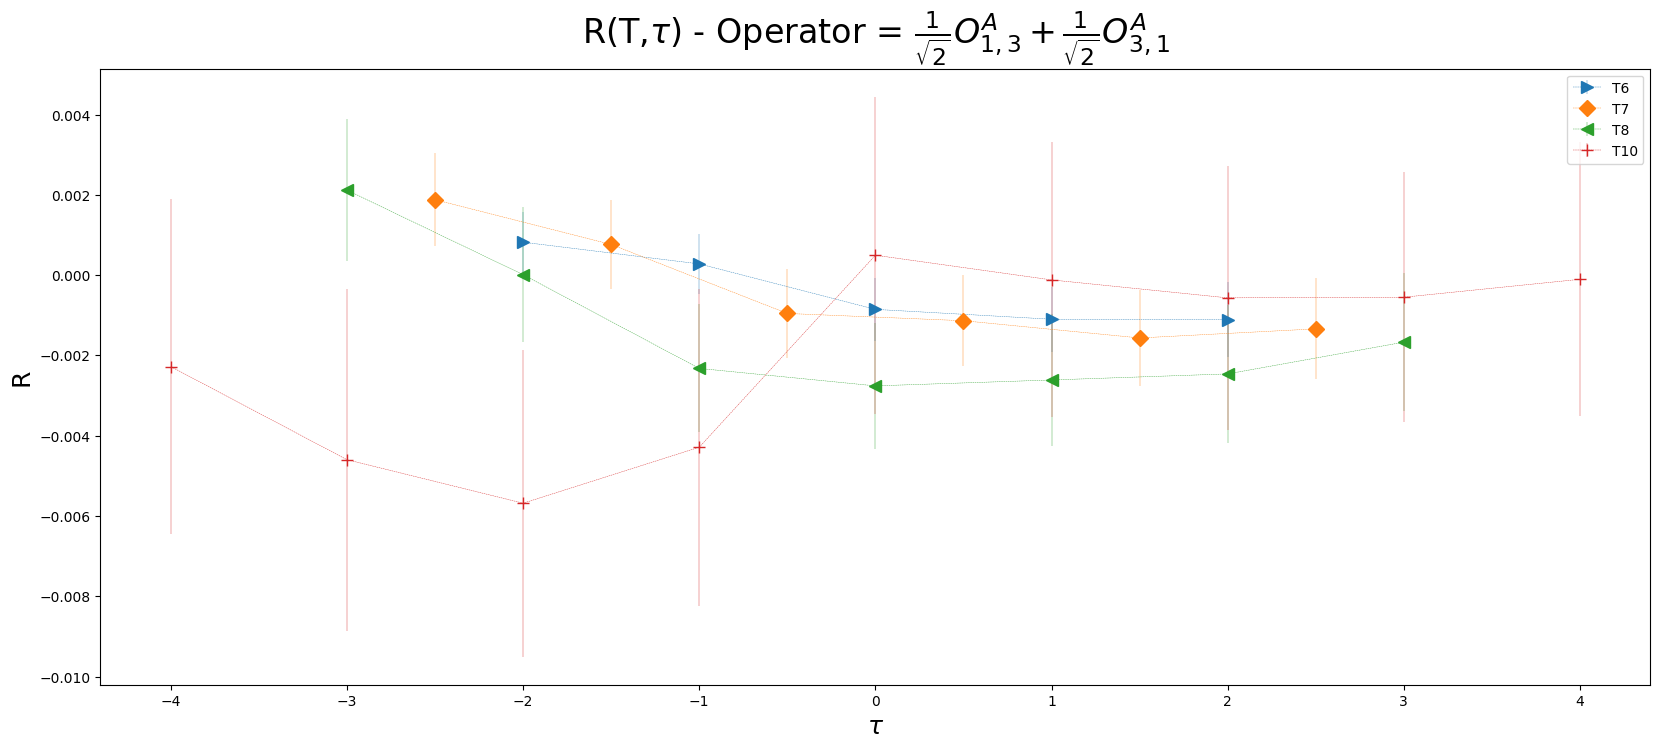

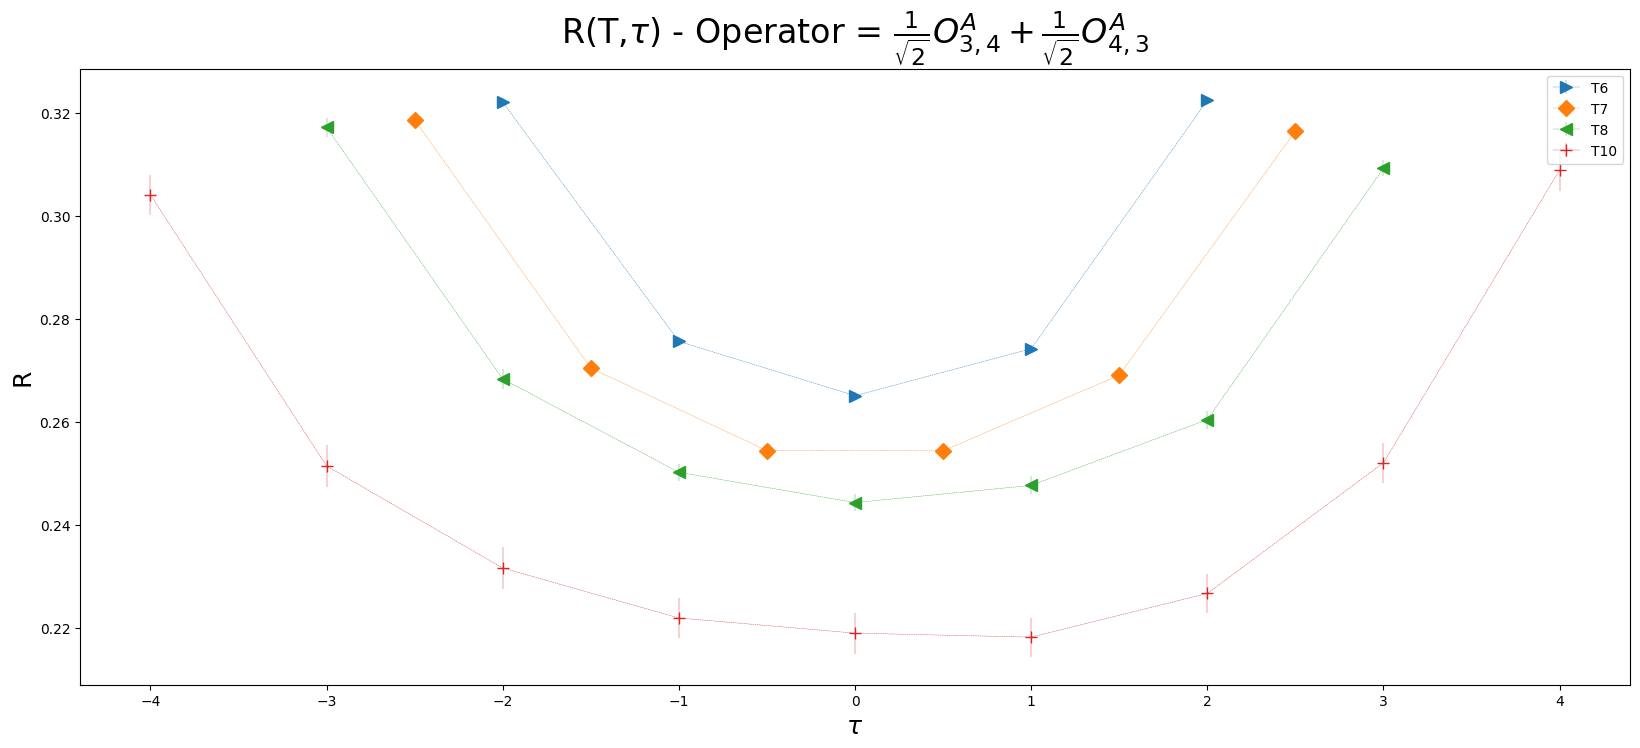

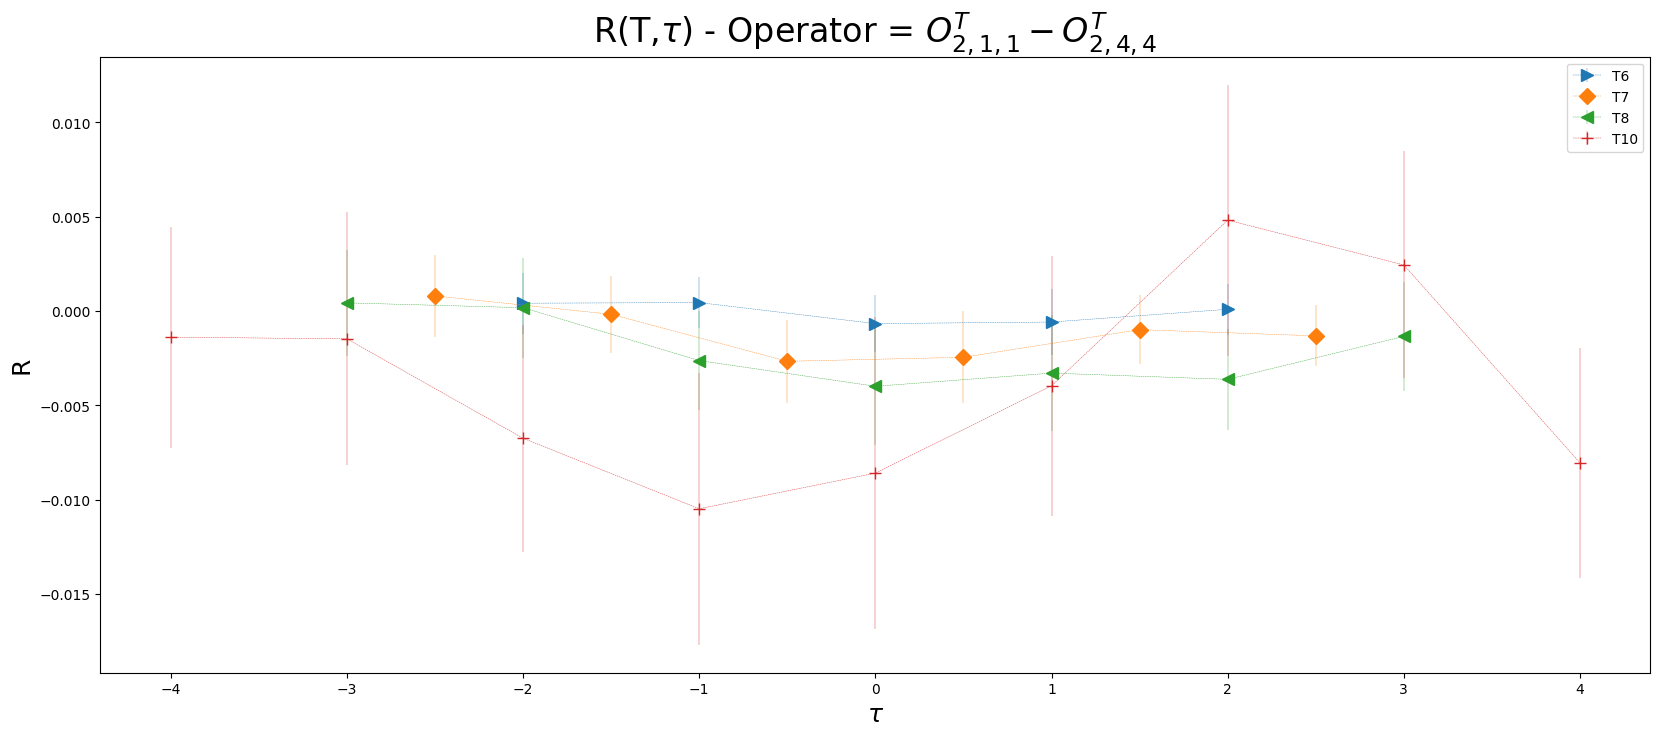

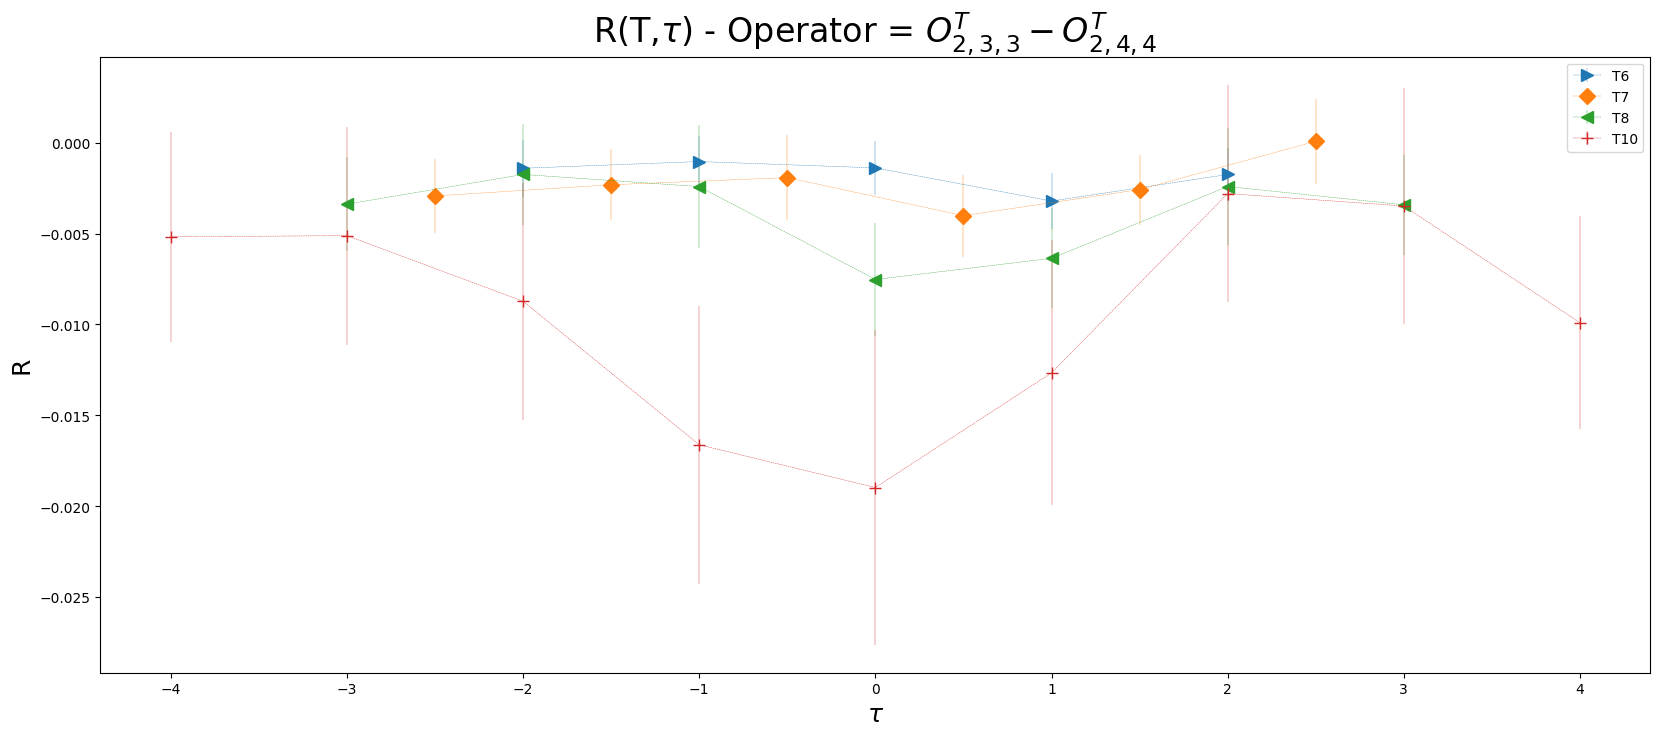

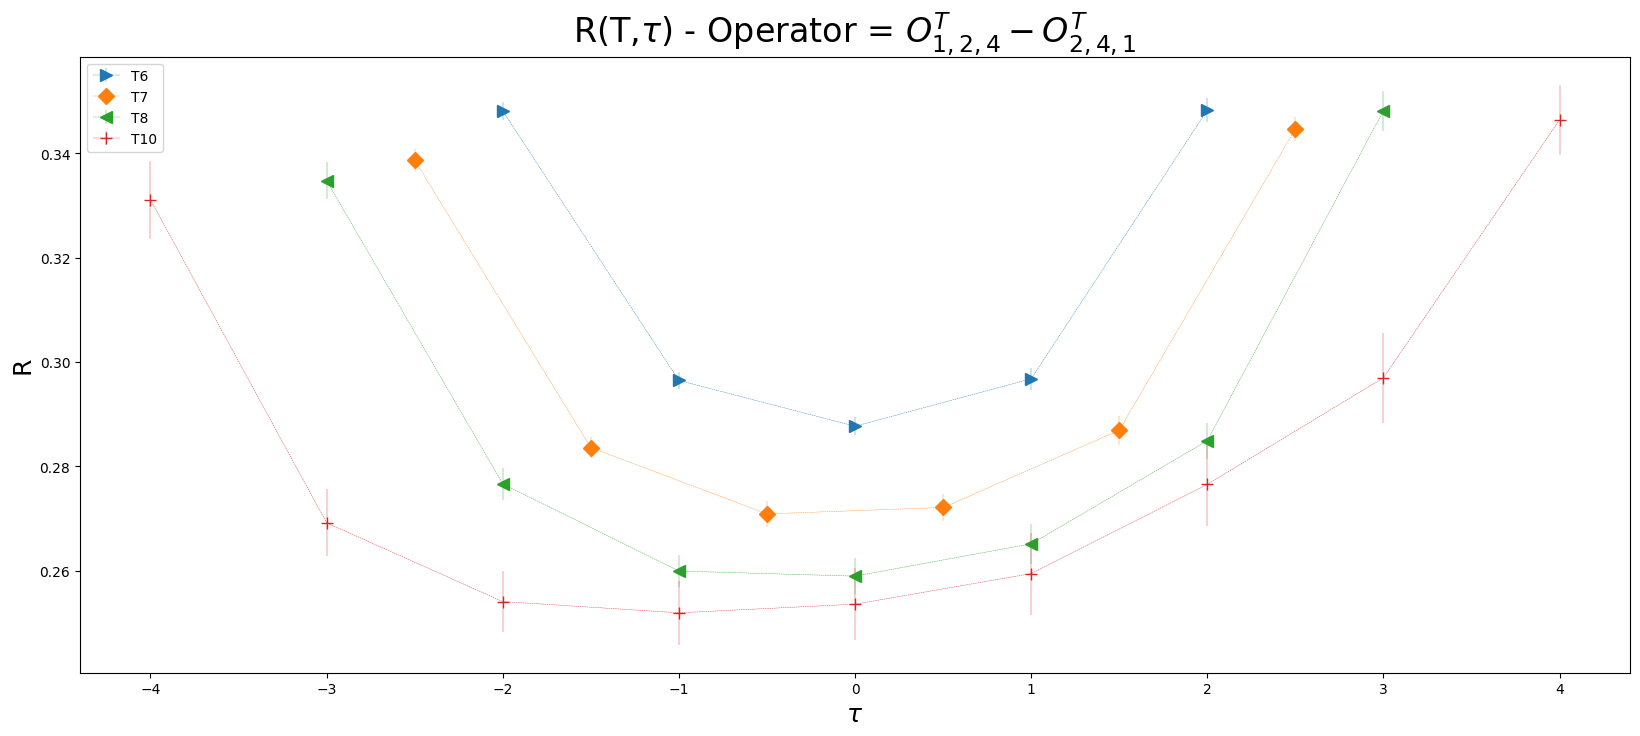

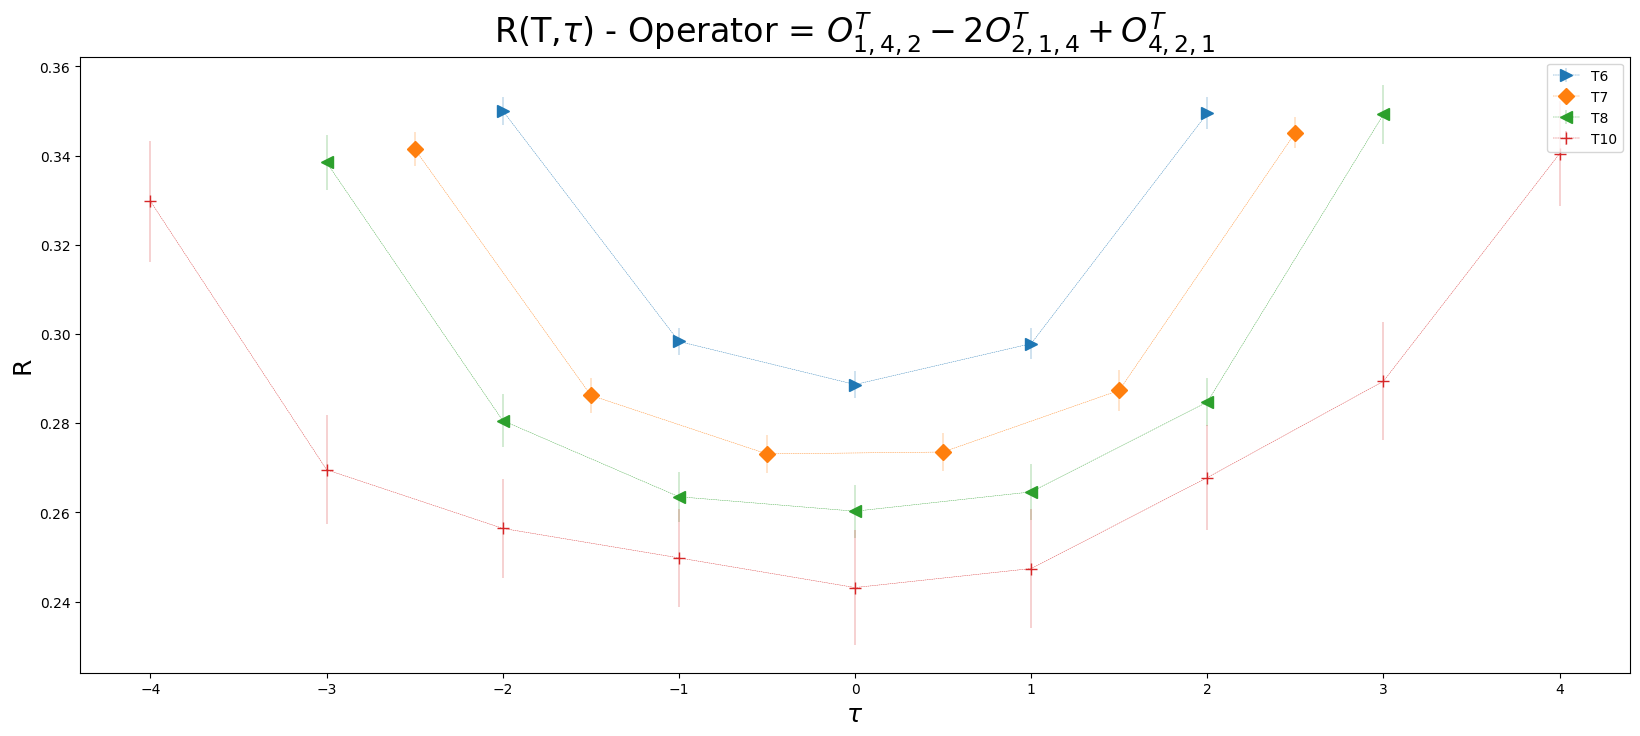

In [6]:
_ = opAnalyzer.plot_R(rescale=True)

In [7]:
fit_state = opAnalyzer.fit_2pcorr(zoom=5,show=False,save=False)

In [8]:
par = fit_state.model_average()
par.keys()
par['est']['E0']


a = 0.1163

par['est']['E0'] /a * 197.327

1000/197.327 * a

dict_keys(['est', 'err', 'res'])

np.float64(0.5466283145238624)

np.float64(927.4679743770439)

0.5893770239247543

# Fit: $\mathcal{M}$ from $R$

In [9]:
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

"(Nop, NT, max(T)+1 )"
Rmean.shape 

'(Nop, NT, max(T)+1 )'

(9, 4, 11)

In [10]:
Smean, Sstd = opAnalyzer.get_S(tskip=1)

"(Nop, NT)"
Smean.shape

"(Nop, NT)"
Sstd.shape

'(Nop, NT)'

(9, 4)

'(Nop, NT)'

(9, 4)

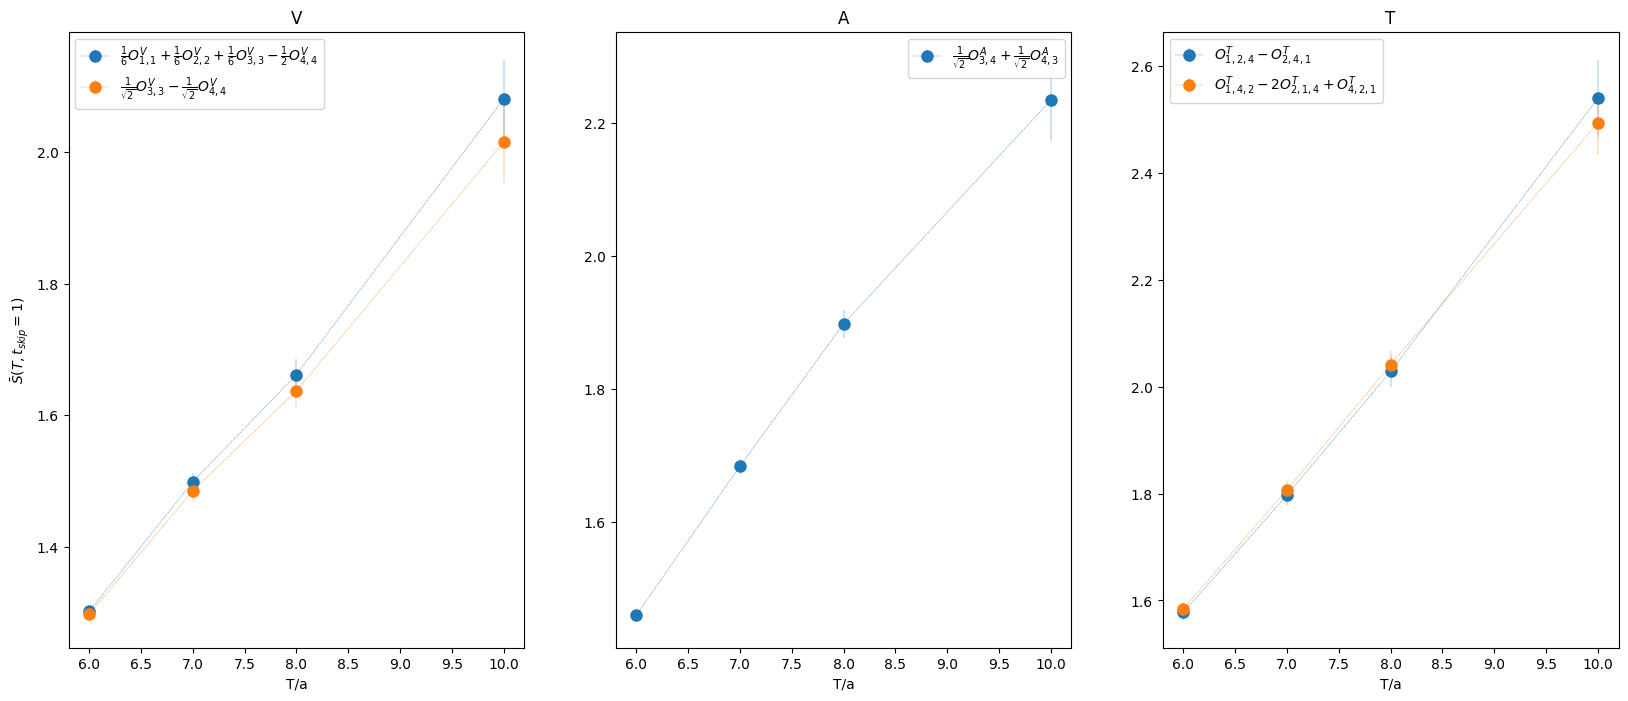

In [11]:
_ = opAnalyzer.plot_S(tskip=1)

## $\mathcal{M}$ from $S$

In [12]:
p2corr = opAnalyzer.get_p2corr()
p3corr = opAnalyzer.get_p3corr()

In [13]:
p3corr.shape

(9, 212, 4, 11)

In [14]:
from moments_toolkit import ratio_formula, sum_ratios_formula

In [15]:
def mat_from_S(p3, p2, Tlist):

    for it,T in enumerate(Tlist):
            ratio_formula(p3,p2, T=T, gauge_axis=1)

In [16]:
tskip_list = [1,2,3]

S_list = np.zeros(shape=(len(opAnalyzer.selected_op), len(opAnalyzer.T_list), len(tskip_list)), # = (Nop, NT, Ntskip)
               dtype=float)

for i_tskip, tskip in enumerate(tskip_list):

    for iT , T in enumerate(opAnalyzer.T_list):

        S_list[:,iT,i_tskip] = sum_ratios_formula( ratio_formula(p3corr[:,:,iT,:],p2corr, T=T, gauge_axis=1), T, tskip, time_axis=-1)

"(Nop, NT, Ntskip)"
S_list.shape

'(Nop, NT, Ntskip)'

(9, 4, 3)

In [17]:
delta_list = [1,2,3]

MatEle_list = []

for iT, iT_value in enumerate(opAnalyzer.T_list):

    for delta in delta_list:
        
        if iT_value + delta in opAnalyzer.T_list:

            print(f"T={iT_value} - delta={delta}")

            iT_plus_delta = opAnalyzer.T_list.index(iT_value + delta)

            MatEle_list.append( (S_list[:,iT_plus_delta,:] - S_list[:,iT,:])/delta )

MatEle_list = np.asarray( MatEle_list )

"(Nallowed, Nop, Ntskip)"
MatEle_list.shape

T=6 - delta=1
T=6 - delta=2
T=7 - delta=1
T=7 - delta=3
T=8 - delta=2


'(Nallowed, Nop, Ntskip)'

(5, 9, 3)

In [18]:
import gvar as gv
fit_state = opAnalyzer.fit_2pcorr(zoom=10, show=False, save=False)

fit_state.model_average()

m = gv.gvar(fit_state.model_average()["est"]['E0'], fit_state.model_average()["err"]['E0'])

{'est': {'A0': np.float64(5.308327039055175e-12),
  'E0': np.float64(0.5466283145238624),
  'dE1': np.float64(0.3922008817839801),
  'A1': np.float64(3.699381485479856e-12)},
 'err': {'A0': np.float64(5.535359708932159e-14),
  'E0': np.float64(0.000956808377497308),
  'dE1': np.float64(0.00883957719478293),
  'A1': np.float64(2.0452986534397946e-13)},
 'res': {'A0': array([5.40219536e-12, 5.32790721e-12, 5.31405816e-12, 5.30974298e-12,
         5.28604618e-12, 5.39067673e-12, 5.33369061e-12, 5.27185524e-12,
         5.30327769e-12, 5.24087828e-12, 5.31249120e-12, 5.30416922e-12,
         5.24808004e-12, 5.26659697e-12, 5.43389384e-12, 5.29464705e-12,
         5.51869577e-12, 5.26776396e-12, 5.34138539e-12, 5.30692767e-12,
         5.31534069e-12, 5.36586825e-12, 5.32280507e-12, 5.32144218e-12,
         5.34329071e-12, 5.23489221e-12, 5.28347242e-12, 5.34693652e-12,
         5.25465815e-12, 5.36223827e-12, 5.26304541e-12, 5.33345478e-12,
         5.30053968e-12, 5.32660502e-12, 5.344443

In [19]:
for iop in range(len(opAnalyzer.selected_op)):
    op = opAnalyzer.selected_op[iop]
    
    op.X
    
    MatEle_list[:,iop,:]

   

    kin = 1j * op.evaluate_K(m_value=m.mean, E_value=m.mean,p1_value=0,p2_value=0,p3_value=0) #this 1j in front comes from the fact that mat_ele = <x> * i K
    if np.iscomplex(kin):
        kin *= -1j
    kin = kin.real
    if kin != 0:  
        np.mean(MatEle_list[:,iop,:]) / kin

'V'

array([[0.05816612, 0.06121421, 0.06595496],
       [0.05310157, 0.05693177, 0.06218258],
       [0.04803702, 0.05264934, 0.0584102 ],
       [0.05726489, 0.05819313, 0.05881744],
       [0.06187883, 0.06096503, 0.05902106]])

np.float64(0.21289009707087414)

'V'

array([[0.07835627, 0.08316869, 0.09147177],
       [0.07086178, 0.07701438, 0.08570747],
       [0.06336728, 0.07086008, 0.07994318],
       [0.07375872, 0.07513634, 0.07730507],
       [0.07895444, 0.07727447, 0.07598601]])

np.float64(0.1999296600639444)

'V'

array([[0.00258262, 0.00191096, 0.00166292],
       [0.00538339, 0.00463425, 0.00367411],
       [0.00818416, 0.00735755, 0.0056853 ],
       [0.0132967 , 0.01120073, 0.0066211 ],
       [0.01585297, 0.01312231, 0.007089  ]])

'A'

array([[-0.00039363, -0.00121978, -0.00123726],
       [-0.0038665 , -0.00423365, -0.00341942],
       [-0.00733937, -0.00724752, -0.00560158],
       [-0.00509723, -0.0041229 , -0.00267819],
       [-0.00397615, -0.0025606 , -0.00121649]])

'A'

array([[-0.09331509, -0.09725615, -0.1015635 ],
       [-0.09125333, -0.09502963, -0.09941781],
       [-0.08919157, -0.0928031 , -0.09727213],
       [-0.07648529, -0.0795472 , -0.08454605],
       [-0.07013216, -0.07291924, -0.07818302]])

np.float64(0.22748277146581797)

'T'

array([[-0.00649603, -0.00547595, -0.00445155],
       [-0.00699111, -0.00628338, -0.00462702],
       [-0.00748618, -0.0070908 , -0.00480249],
       [-0.00885432, -0.00588362, -0.00659498],
       [-0.00953838, -0.00528003, -0.00749122]])

'T'

array([[-0.00488785, -0.00518611, -0.00454364],
       [-0.00923802, -0.00741581, -0.00746065],
       [-0.01358819, -0.00964551, -0.01037766],
       [-0.02323063, -0.01915703, -0.01791843],
       [-0.02805185, -0.02391279, -0.02168882]])

'T'

array([[0.12939712, 0.13708824, 0.15049119],
       [0.13298264, 0.13694925, 0.14629076],
       [0.13656816, 0.13681027, 0.14209033],
       [0.14595007, 0.14709289, 0.14792778],
       [0.15064102, 0.1522342 , 0.15084651]])

np.float64(0.26140375438778)

'T'

array([[0.26232014, 0.27750281, 0.30408541],
       [0.26935926, 0.27632872, 0.29451241],
       [0.27639838, 0.27515463, 0.28493942],
       [0.269995  , 0.27644517, 0.28217582],
       [0.26679331, 0.27709044, 0.28079402]])

np.float64(0.2545236471062442)

In [20]:
matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[1])

#matele_fromS = matele_fromS[:,:2]

In [21]:
opAnalyzer.selected_op

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[1, 4]/1000000000000000 + 707106781186547*O[4, 1]/1000000000000000,
 707106781186547*O[1, 3]/1000000000000000 + 707106781186547*O[3, 1]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[2, 1, 1] - O[2, 4, 4],
 O[2, 3, 3] - O[2, 4, 4],
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

In [22]:
matele_fromS

"(Nop, nT-1)"
matele_fromS.shape

array([[0.0408(65), 0.071(14), 0.180(40)],
       [0.060(10), 0.151(27), 0.364(81)],
       [-0.037(16), -0.034(20), -0.087(44)],
       [0.0069(23), 0.030(19), 0.086(49)],
       [-0.109(22), -0.127(35), -0.50(12)],
       [0.0187(81), 0.039(27), -0.150(48)],
       [-0.056(20), 0.045(23), 0.041(28)],
       [0.095(12), 0.125(27), 0.082(62)],
       [0.221(20), 0.201(54), -0.29(22)]], dtype=object)

'(Nop, nT-1)'

(9, 3)

In [23]:
matele_fromS[0]

array([0.0408(65), 0.071(14), 0.180(40)], dtype=object)

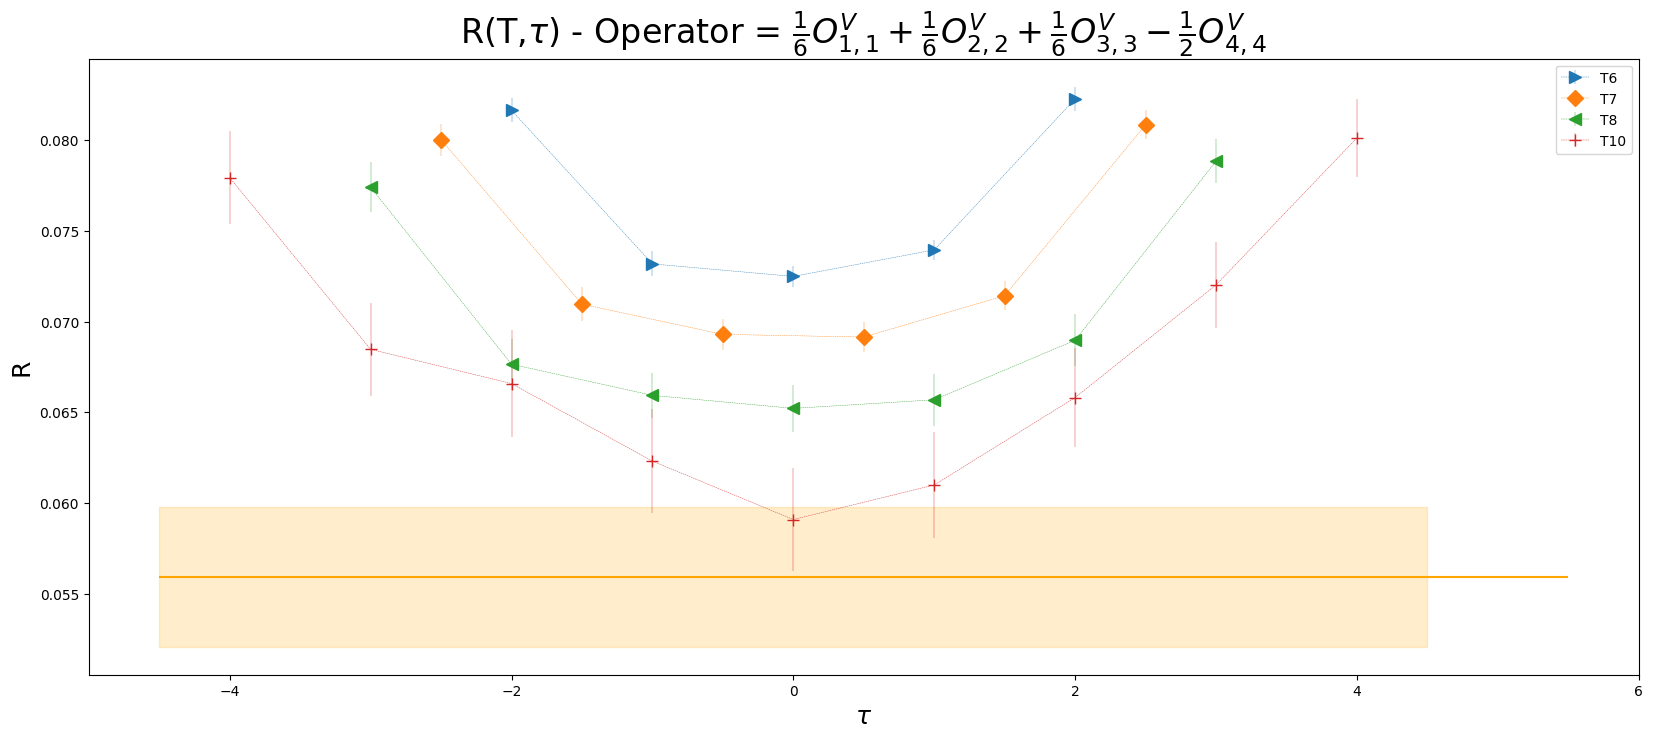

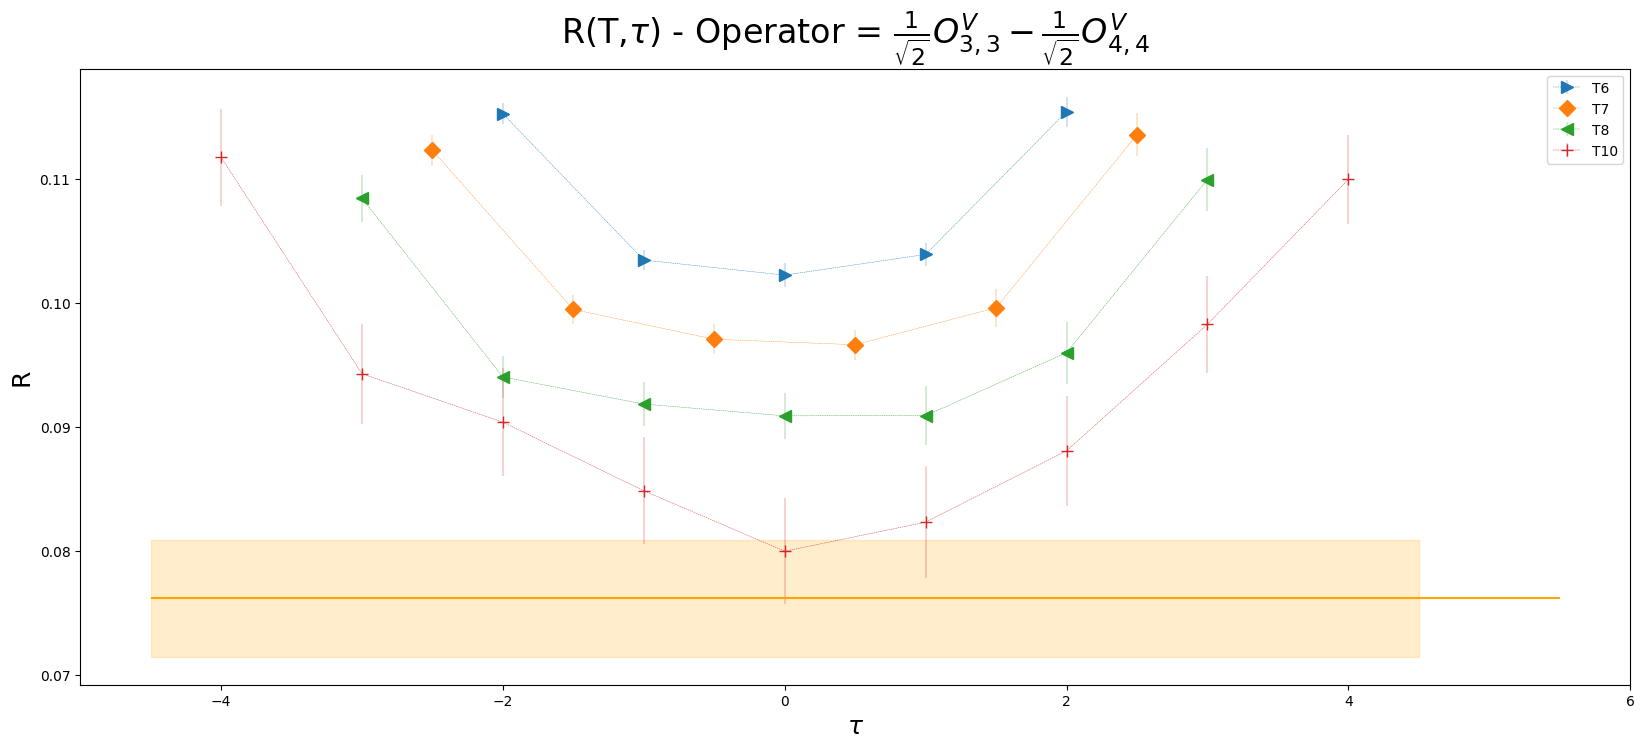

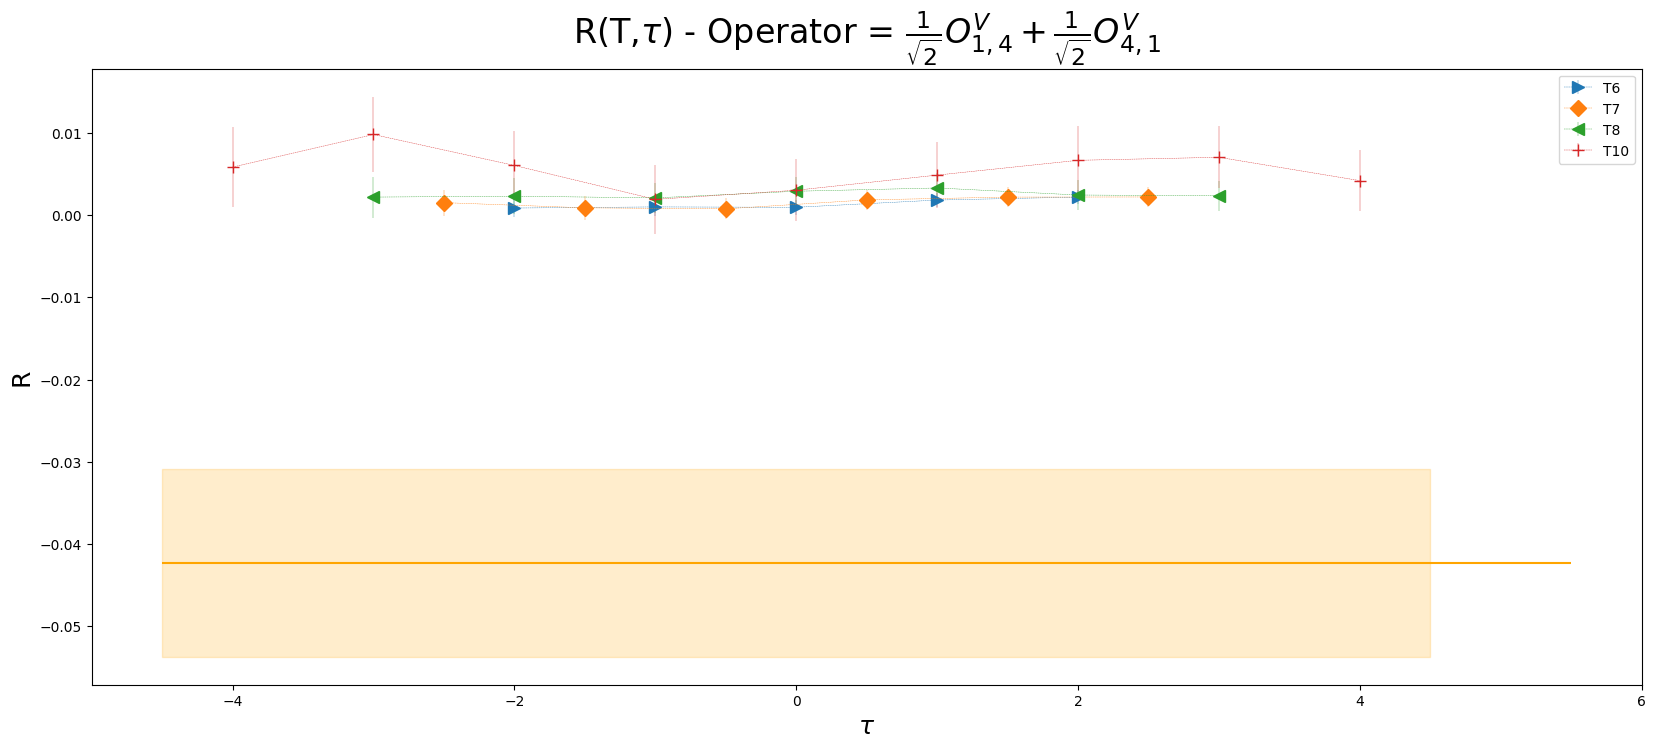

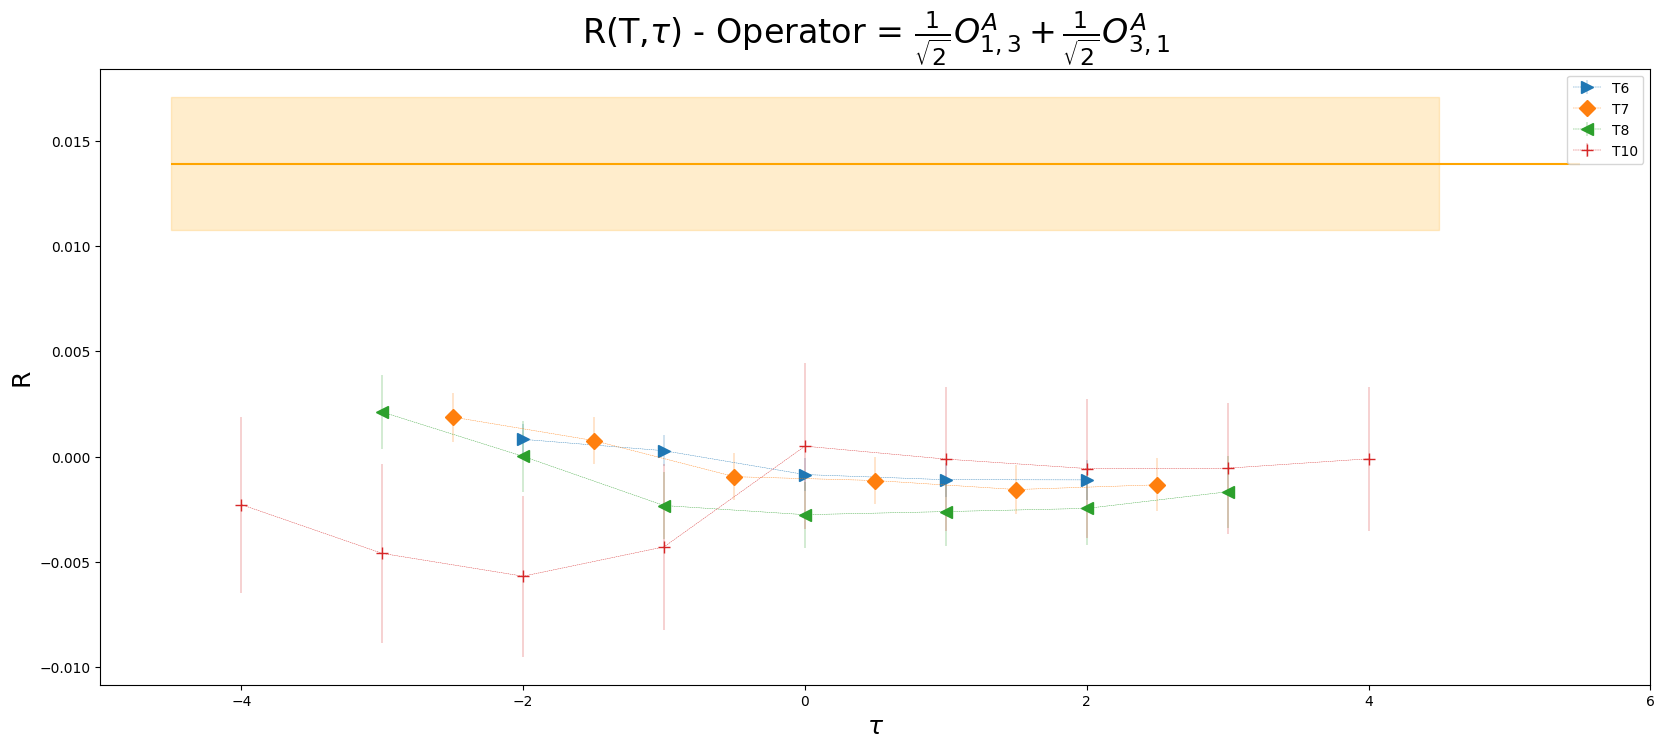

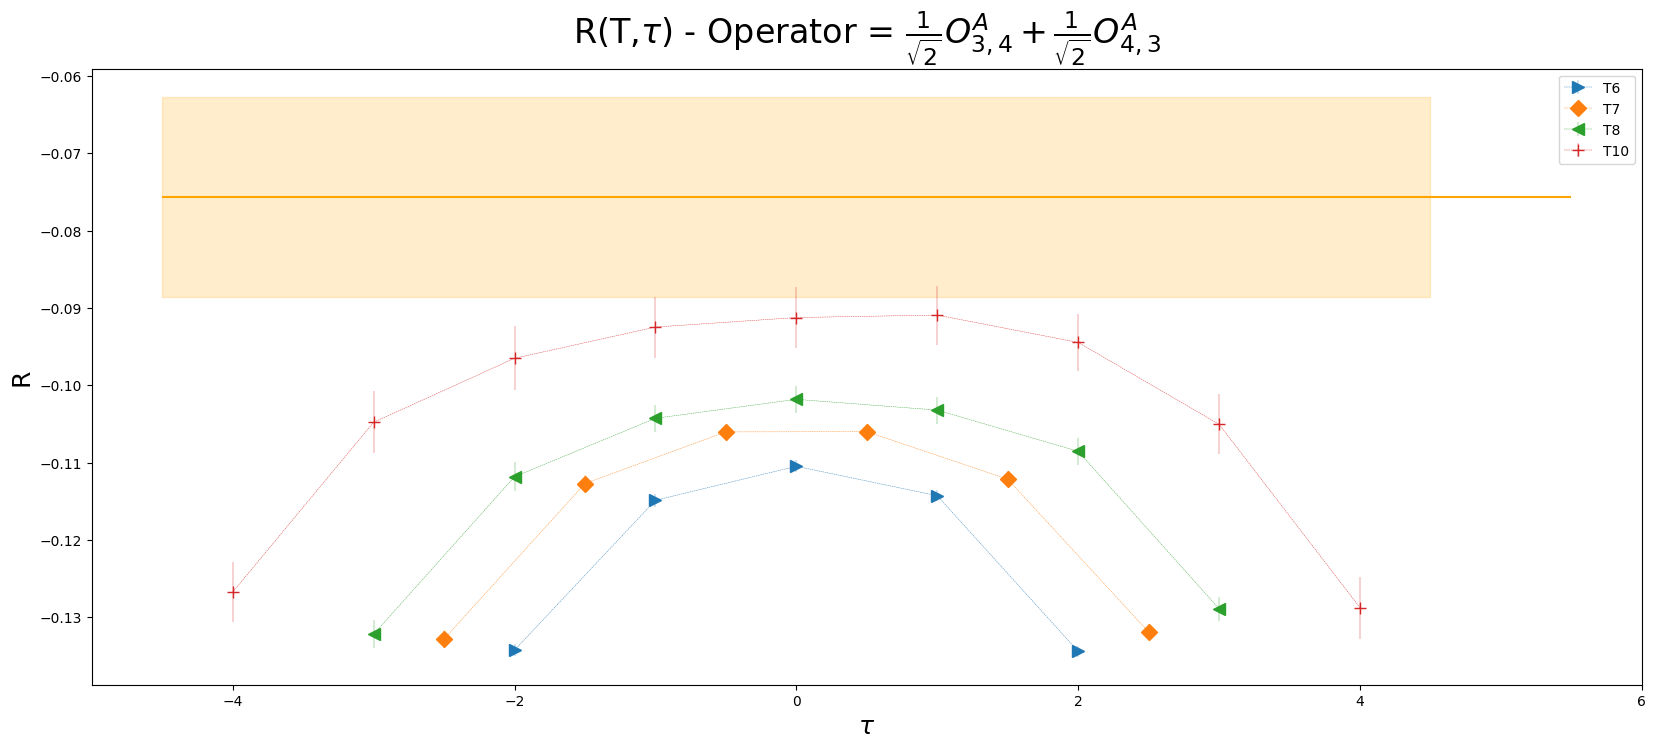

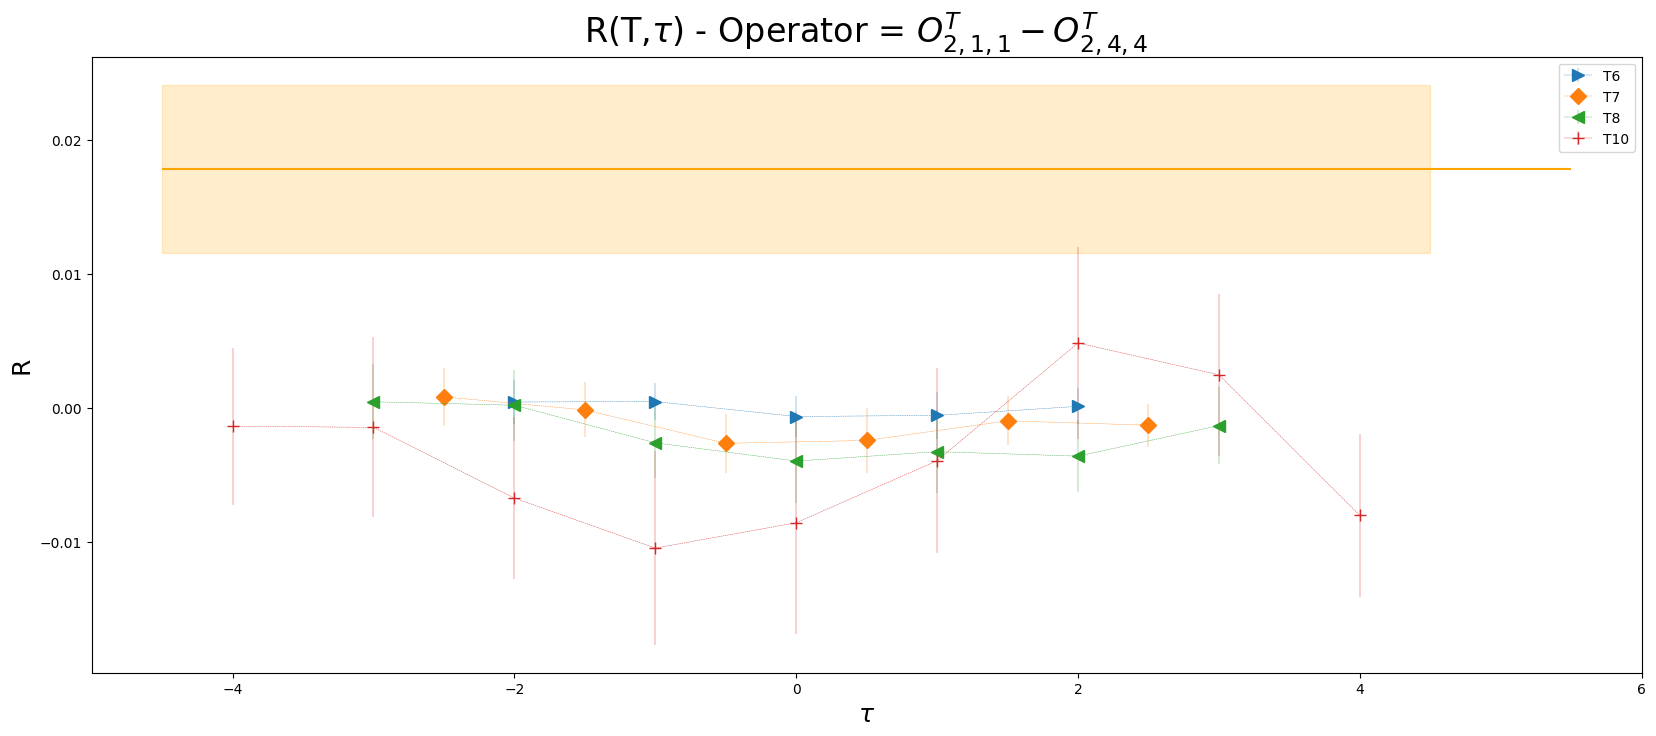

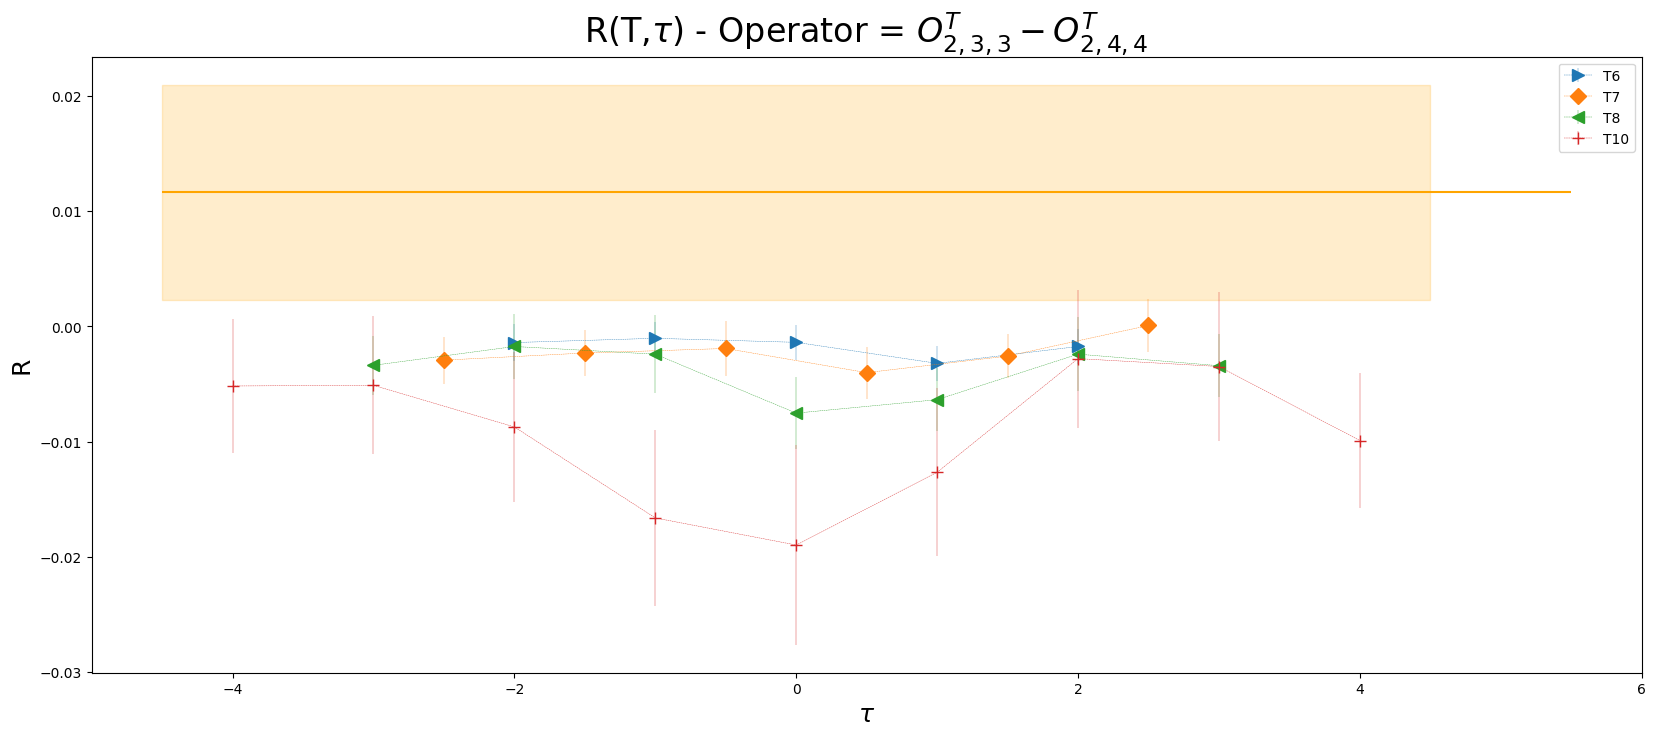

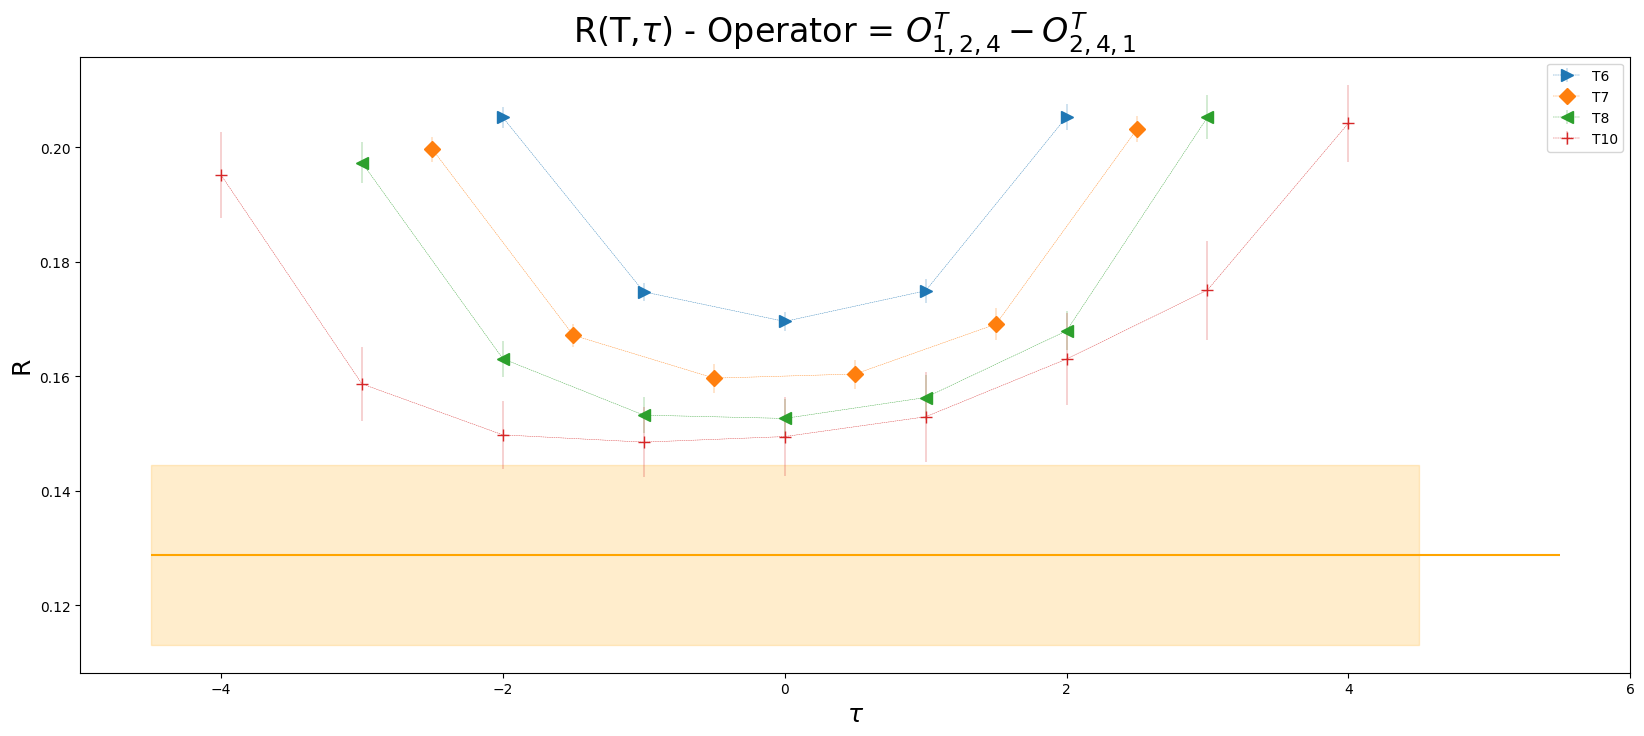

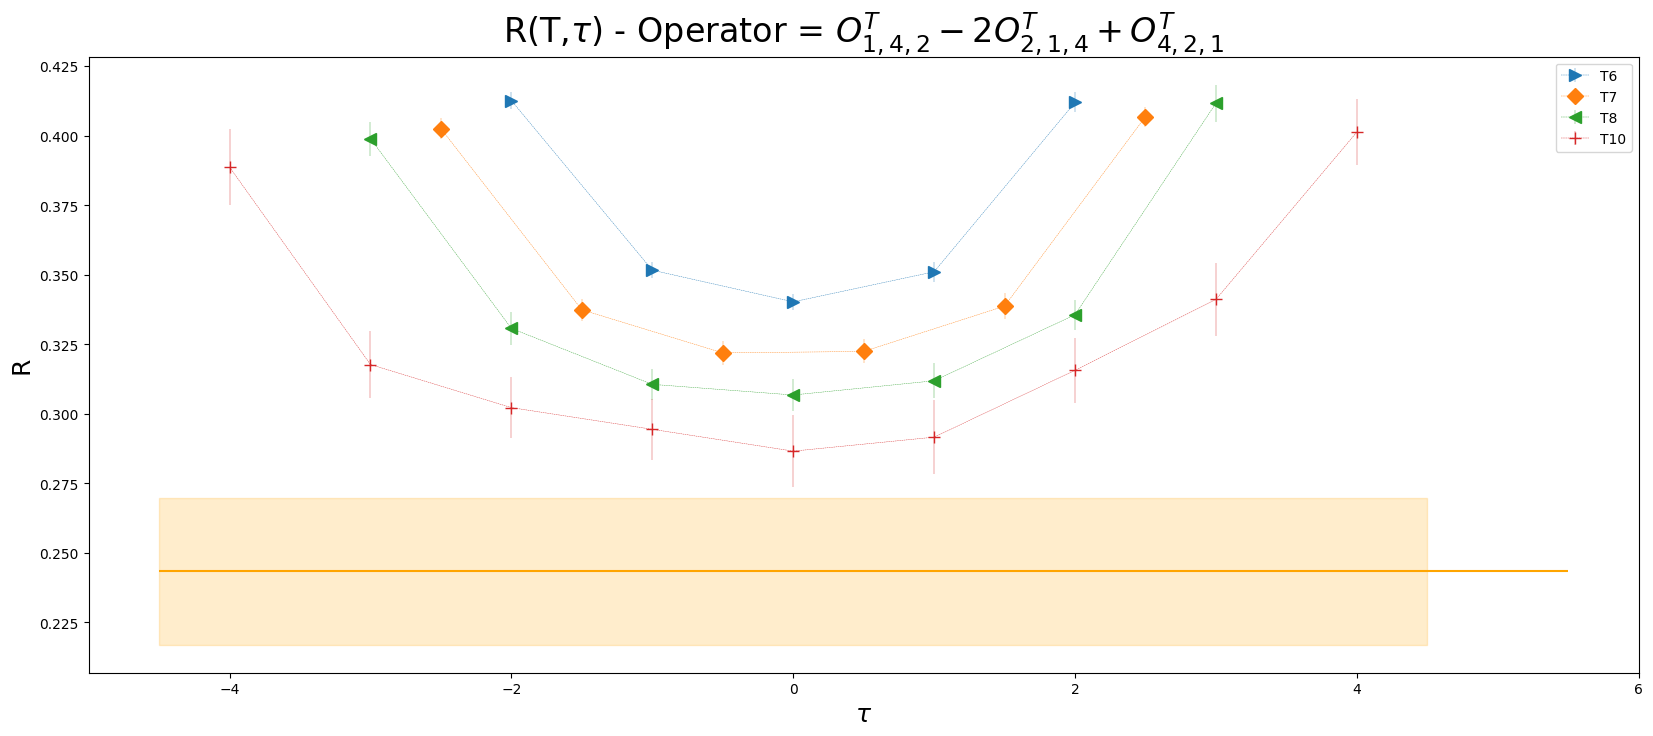

In [92]:
fig_ax_list = opAnalyzer.plot_R(rescale=False,show=False,save=True)

for iop, fig_ax in enumerate(fig_ax_list):

    a = 0.1163 #we cheat
    hc = 197.327
    mp_mev = 1000
    mass = mp_mev/hc * a

    #op = opAnalyzer.selected_op[iop]
    #
    #kin = op.evaluate_K_real(m_value=mass,E_value=mass,p1_value=0,p2_value=0,p3_value=0)
    #
    #print(kin)
    #
    #if np.abs(kin)<10**-7:
    #    print(iop)
    #    continue

    fig, ax = fig_ax

    mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] ) #/ kin
    #mat_ele_avg = matele_fromS[iop][2]

    T=11

    _ = ax.hlines(mat_ele_avg.mean,-T/2+1,T/2,linestyle="solid", color="orange")
    #ax.hlines(mat_ele_avg.mean + mat_ele_avg.std, -T/2+1,T/2,linestyle="solid", color="orange", alpha)
    #ax.hlines(mat_ele_avg.mean - mat_ele_avg.std,-T/2+1,T/2,linestyle="solid", color="orange")
    _ = ax.fill_between(np.arange(-T/2+1,T/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")

plt.show()


# ?????????????

## $\mathcal{M}$ from fit

In [143]:
#we will use as prior the value extracted from S
matele_fromS = opAnalyzer.MatEle_from_S()

mat_ele_prior = np.mean(matele_fromS,axis=1)

mat_ele_prior

"(Nop, )"
mat_ele_prior.shape

array([0.0859(95), 0.128(14), -0.060(16), 0.0239(90), -0.062(17),
       0.033(15), 0.011(11), 0.101(23), 0.153(48)], dtype=object)

'(Nop, )'

(9,)

In [144]:
#first we take the value of R
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

In [145]:
Rmean.shape
Rcovmat.shape

(9, 4, 11)

(9, 4, 11, 11)

In [146]:
from moments_toolkit import plateau_search

In [147]:
#we search for the plateau for each op and for each T



for iT,T in enumerate(opAnalyzer.T_list):

    #T

    for iop,op in enumerate(opAnalyzer.selected_op):
            
        if op.evaluate_K_real(m_value=1,E_value=1,p1_value=0,p2_value=0,p3_value=0) ==0:
            continue

        
            

        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=1.0)
        #start_plateau, end_plateau



allowedT = np.empty(shape=(opAnalyzer.Nop,), dtype=list)
plateau_dict = {}

for iop,op in enumerate(opAnalyzer.selected_op):

    allowedT[iop] = []

    for iT,T in enumerate(opAnalyzer.T_list):

        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=1.5)

        plateau_dict[(iop,iT)] = start_plateau, end_plateau

        for tau in range(start_plateau,end_plateau):
            allowedT[iop].append( (T,tau) )

allowedT[0]

[(6, 2),
 (6, 3),
 (7, 3),
 (7, 4),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (10, 2),
 (10, 3)]

In [148]:
fit2p = opAnalyzer.fit_2pcorr(show=False,save=False)

In [149]:
fit2p_parms = fit2p.model_average()

dE1 = gv.gvar(fit2p_parms['est']['dE1'], fit2p_parms['err']['dE1'])

dE1

E0 = gv.gvar(fit2p_parms['est']['E0'], fit2p_parms['err']['E0'])

E0

0.3922(88)

0.54663(96)

In [150]:
a = 0.1163 #we cheat
hc = 197.327
dE1 *hc /a

E0 *hc /a

665(15)

927.5(1.6)

In [151]:
opAnalyzer.get_p3corr().shape

(9, 212, 4, 11)

In [152]:
#abscissa = np.ones(shape=Rmean[0].shape)
#
#abscissa = np.cumsum(abscissa, axis=1) -1
#
#abscissa.shape

#abscissa = [ [(T,tau) for tau in range(0,T+1)] for T in opAnalyzer.T_list ]
#abscissa = np.asarray( [e for l in abscissa for e in l] )


#abscissa.shape


In [153]:
from moments_toolkit import ratio_formula

def jackknife_resamples(in_array_list: np.ndarray|list[np.ndarray], observable, jack_axis_list:int|list[int|None]=0, binsize:int=1,first_conf:int=0, last_conf:int|None=None) -> list[np.ndarray]:
    """
    Function returning the jackknife resamples of the given observablem that can be computed with the given inputs.

    Input:
        - in_array_list: input array to be jackknifed, or a list containing such arrays
        - observable: function taking as input an array of the same shape of in_array (i.e. an observable that should be computed over it), and giving as output an array with the jackknife axis (i.e. conf axis) removed
        - jack_axis_list: the axis over which perform the jacknife analysis (from a physics p.o.v. the axis with the configurations) (or a list with such axis for every input array)
        - binsize: binning of the jackknife procedure
        - first_conf: index of the first configuration taken into account while performing the jackknife procedure
        - last_conf: index of the last configuration taken into account while performing the jackknife procedure (if not specified then the last available configuration is used)

    Output:
        - list with [mean, std, cov] where mean and std are np array with same the same shape as the input one minus the jackknife dimension, and the cov has one extra time dimension (the new time dimension is now the last one)
    """

    #we make a check on the input to asses that the number of input_array, jackknife axes and time_axes is consistend
    if type(in_array_list) is list and (type(jack_axis_list) is not list or len(in_array_list)!=len(jack_axis_list) ):
        raise ValueError("The input array is a list, hence also the jackknife axis should be a list and have the same lenght, but that is not the case")
    
    #if the given input is just one array and not a list of arrays, then we put it in a list
    if type(in_array_list) is not list:
        in_array_list = [in_array_list]
        jack_axis_list = [jack_axis_list]

    #we set last conf to its default value
    if last_conf is None:
        last_conf = np.shape(in_array_list[0])[jack_axis_list[0]]

    #step 1: creation of the jackknife resamples (we create a jack resample for input array in the list)
    jack_resamples_list = [ np.asarray( [np.delete(in_array, list(range(iconf,min(iconf+binsize,last_conf))) ,axis=jack_axis_list[i]) for iconf in range(first_conf,last_conf,binsize)] ) for i,in_array in enumerate(in_array_list)]#shape = (nresamp,) + shape(in_array) (with nconf -> nconf-binsize)

    #the number of resamples is len(jack_resmaples[0]) or also
    #nresamp = int((last_conf-first_conf)/binsize)
    nresamp = np.shape(jack_resamples_list[0])[0] #the 0th axis now is the resample axis, (and axis has nconf-1 conf in the standard case (binsize=1 ecc.) )

    #step 2; for each resample we compute the observable of interest
    #we use the resampled input array to compute the observable we want, and we have nresamp of them
    obs_resamp = np.asarray( [observable( *[jack_resamples[i] for jack_resamples in jack_resamples_list] ) for i in range(nresamp) ] )                                                                          #shape = (nresamp,) + output_shape

    return obs_resamp

In [154]:
class ratio_func_form:

    def __init__(self,r1:bool=True,r2:bool=True,r3:bool=False):
        self.r1:bool=r1
        self.r2:bool=r2
        self.r3:bool=r3
        
    def __call__(self, t:tuple[int,int], parms:dict):

        #we grep the input
        T = t[:,0]
        tau = t[:,1]
        MatEle = parms["M"]
        R1 = parms["R1"]
        R2 = parms["R2"]
        R3 = parms["R3"]
        dE = parms["dE"]

        out = MatEle

        if self.r1:
            out += R1 * np.exp(-T/2*dE)*np.cosh( (T/2 - tau) * dE)
        if self.r2:
            out += R2 * np.exp(-T*dE)

        if self.r3:
            out /= (1 + R3 * np.exp(-T*dE))

        return out

In [155]:
p3 = opAnalyzer.get_p3corr()
p2 = opAnalyzer.get_p2corr()

iop = 0

ratio = []

for iT,T in enumerate(opAnalyzer.T_list):
    ratio.append( ratio_formula(p3, p2, T, gauge_axis=1)[iop,iT,:T+1] )

ratio = [e for l in ratio for e in l]

In [156]:
np.asarray( [e for l in [ ratio_formula(p3, p2, T, gauge_axis=1)[iop,iT,:T+1] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] )

array([-0.03516548,  0.08163267,  0.07317353,  0.0724838 ,  0.07394545,
        0.08226424, -0.03496907, -0.03595253,  0.08001236,  0.0709555 ,
        0.0692919 ,  0.06914686,  0.07142272,  0.08083646, -0.03573677,
       -0.03723329,  0.07740243,  0.06765001,  0.06593704,  0.06522097,
        0.06569095,  0.06896734,  0.07883407, -0.03670119, -0.03728262,
        0.07793754,  0.06847756,  0.06659554,  0.0623301 ,  0.05911739,
        0.06101886,  0.06582919,  0.07202774,  0.08012656, -0.03820808])

In [157]:
ratio_res2 = [ jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] ) for iop in range(opAnalyzer.Nop) ] 

len(ratio_res2)
ratio_res2[1].shape

9

(212, 12)

In [158]:
iop = 0


#ratio_res = jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, :T+1] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] )
ratio_res = jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] )

np.shape(ratio_res)


nres = ratio_res.shape[0]

abscissa = np.asarray( allowedT[iop] )
abscissa.shape

(212, 10)

(10, 2)

In [159]:
len(ratio)
len(abscissa)

35

10

In [160]:
prior = gv.BufferDict()

prior["dE"] = gv.gvar(fit2p_parms['est']['dE1'], fit2p_parms['err']['dE1'])

prior["M"] = mat_ele_prior[iop]

prior["R1"] = gv.gvar(0,10)
prior["R2"] = gv.gvar(0,10)
prior["R3"] = gv.gvar(0,10)

prior

BufferDict({'dE': 0.3922(88), 'M': 0.0859(95), 'R1': 0 ± 10, 'R2': 0 ± 10, 'R3': 0 ± 10})

In [161]:
import correlatoranalyser as CA

In [162]:
abscissa[:,1]

array([2, 3, 3, 4, 2, 3, 4, 5, 2, 3])

In [163]:
#we do the fit
fit_res = CA.fit(

    abscissa                = abscissa,
    
    ordinate_est            = np.mean(ratio_res, axis = 0),
    ordinate_std            = np.sqrt((nres-1)/nres) * np.std (ratio_res, axis = 0),
    ordinate_cov            = (nres-1)/nres * np.cov (ratio_res, rowvar=False),
    
    resample_ordinate_est   = ratio_res,
    resample_ordinate_std   = np.sqrt((nres-1)/nres) * np.std (ratio_res, axis = 0),
    resample_ordinate_cov   = (nres-1)/nres * np.cov (ratio_res, rowvar=False),

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = True,

    resample_fit                 = True,
    resample_fit_correlated      = True,
    
    resample_fit_resample_prior  = False,
    resample_type               = "bst",#"jkn",

    # args for lsqfit:
    model   = ratio_func_form(r1=True,r2=True,r3=False),
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

In [164]:
fit_res

FitResult[ ([6 2],[10  3]), resample:bst]:
  𝜒²/dof [dof] = 226 [10]
  AIC = 2.26e+03 
    - dE: 0.3142(39)  [0.3922(88)]
    - M: 0.05006(48)  [0.0859(95)]
    - R1: 0.0488(13)  [0 ± 10]
    - R2: 0.0215(19)  [0 ± 10]
    - R3: 0 ± 0  [0 ± 10]

In [165]:
fit_state = CA.FitState()

fit_state.append(fit_res)

In [166]:
fit_state.model_average()

{'est': {'dE': np.float64(0.31419842399519005),
  'M': np.float64(0.05006079905021886),
  'R1': np.float64(0.04877002737205815),
  'R2': np.float64(0.021529215457435722),
  'R3': np.float64(0.0)},
 'err': {'dE': np.float64(0.003862691092116139),
  'M': np.float64(0.00047670516695458336),
  'R1': np.float64(0.0012992479058420653),
  'R2': np.float64(0.0018551003973699028),
  'R3': np.float64(0.0)},
 'res': {'dE': array([0.31078986, 0.32290744, 0.30655235, 0.31461965, 0.31354112,
         0.31554528, 0.31409473, 0.31298803, 0.3201743 , 0.31869261,
         0.31656942, 0.31344528, 0.31144477, 0.3141189 , 0.31618198,
         0.31699402, 0.31039938, 0.31089654, 0.31279835, 0.31042389,
         0.31821117, 0.31607443, 0.31252185, 0.30095949, 0.31609075,
         0.31366193, 0.31380603, 0.31197227, 0.31999592, 0.31341858,
         0.31244864, 0.31366434, 0.31272141, 0.30957771, 0.31140846,
         0.31494127, 0.31830839, 0.31465801, 0.32041457, 0.30944286,
         0.31547391, 0.30867483, 0

In [167]:
fit_par_res = fit_res.best_fit_param

In [168]:
deltaE = fit_par_res['dE']

deltaE *hc / a

533(12)

In [169]:
mat_ele_prior

array([0.0859(95), 0.128(14), -0.060(16), 0.0239(90), -0.062(17),
       0.033(15), 0.011(11), 0.101(23), 0.153(48)], dtype=object)

In [170]:
#opAnalyzer.fit_2pcorr(show=True,save=True,zoom=5)

In [171]:
fit_state_list =opAnalyzer.fit_ratio() #TO DO: make to function return the fit state and then debug the plot from there

In [172]:
import itertools as it

In [173]:
start_plateau, end_plateau = plateau_dict[(iop,iT)]

times = np.arange(start_plateau, end_plateau)
times

model = ratio_func_form(r1=True,r2=True,r3=True)


ok = np.asarray( [(T,tau) for tau in times] )
ok
model(ok, post_dict)

array([2, 3])

array([[10,  2],
       [10,  3]])

array([0.3168(29), 0.2998(26)], dtype=object)

In [174]:
np.linspace(3,5,20)

array([3.        , 3.10526316, 3.21052632, 3.31578947, 3.42105263,
       3.52631579, 3.63157895, 3.73684211, 3.84210526, 3.94736842,
       4.05263158, 4.15789474, 4.26315789, 4.36842105, 4.47368421,
       4.57894737, 4.68421053, 4.78947368, 4.89473684, 5.        ])

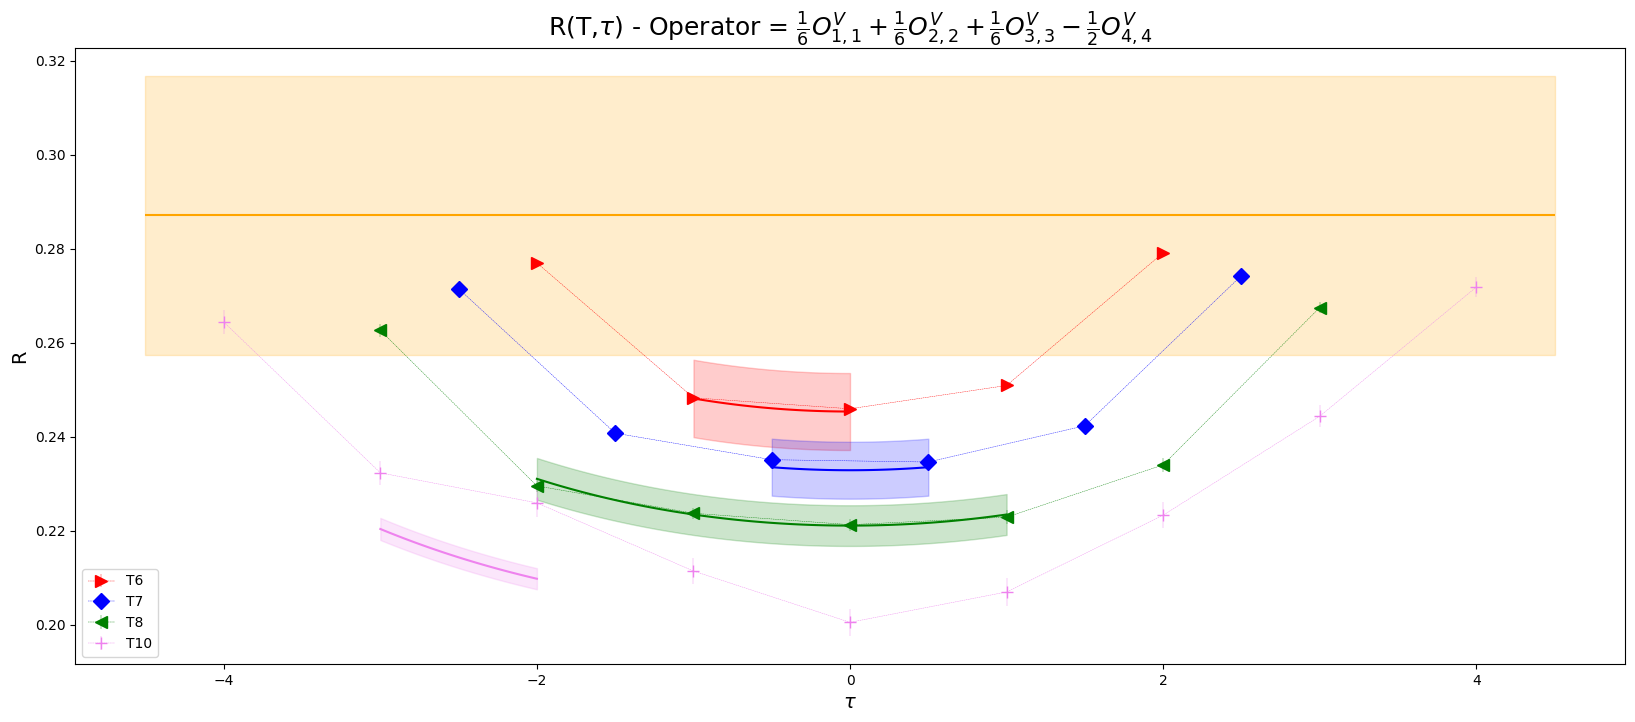

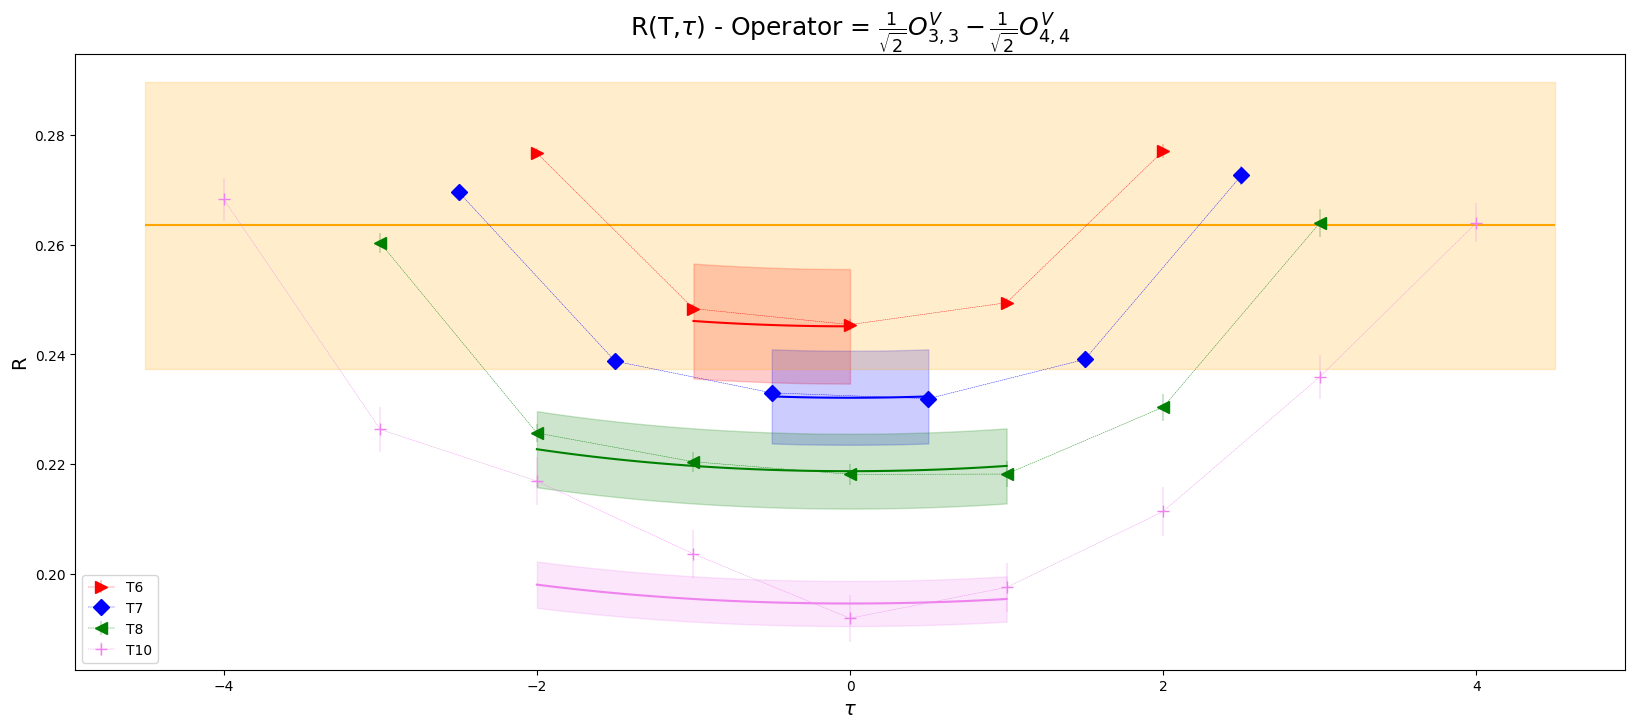

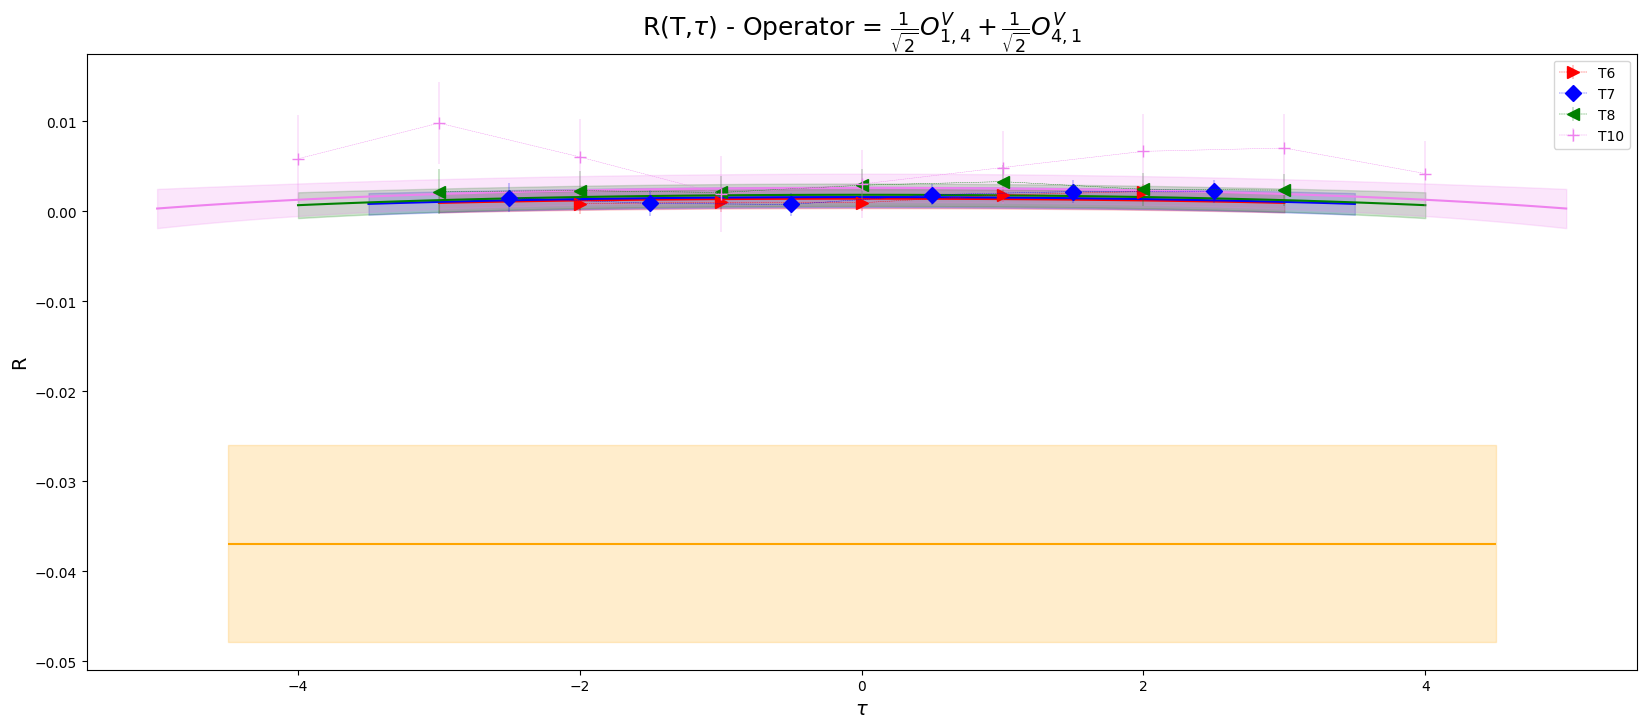

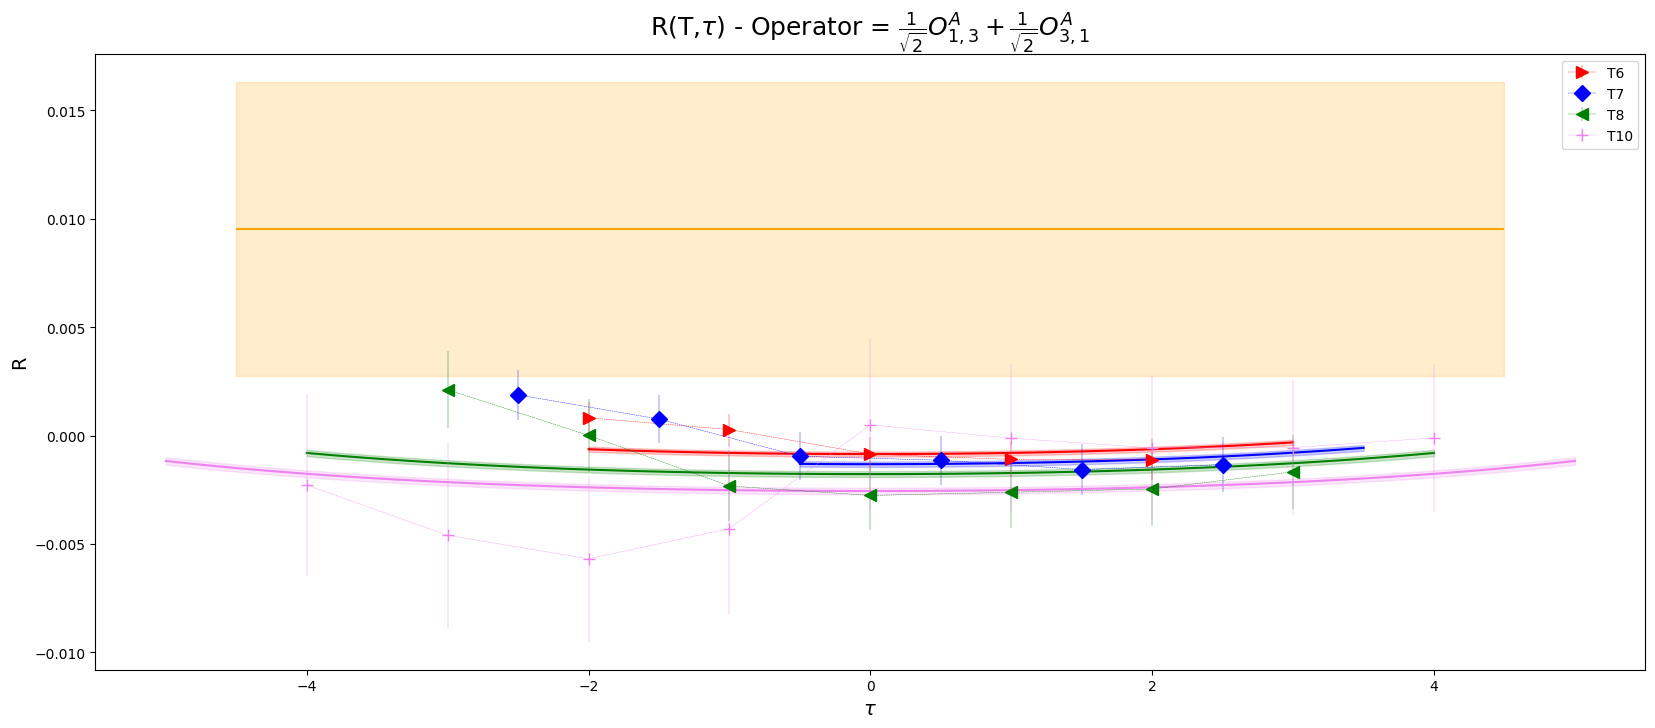

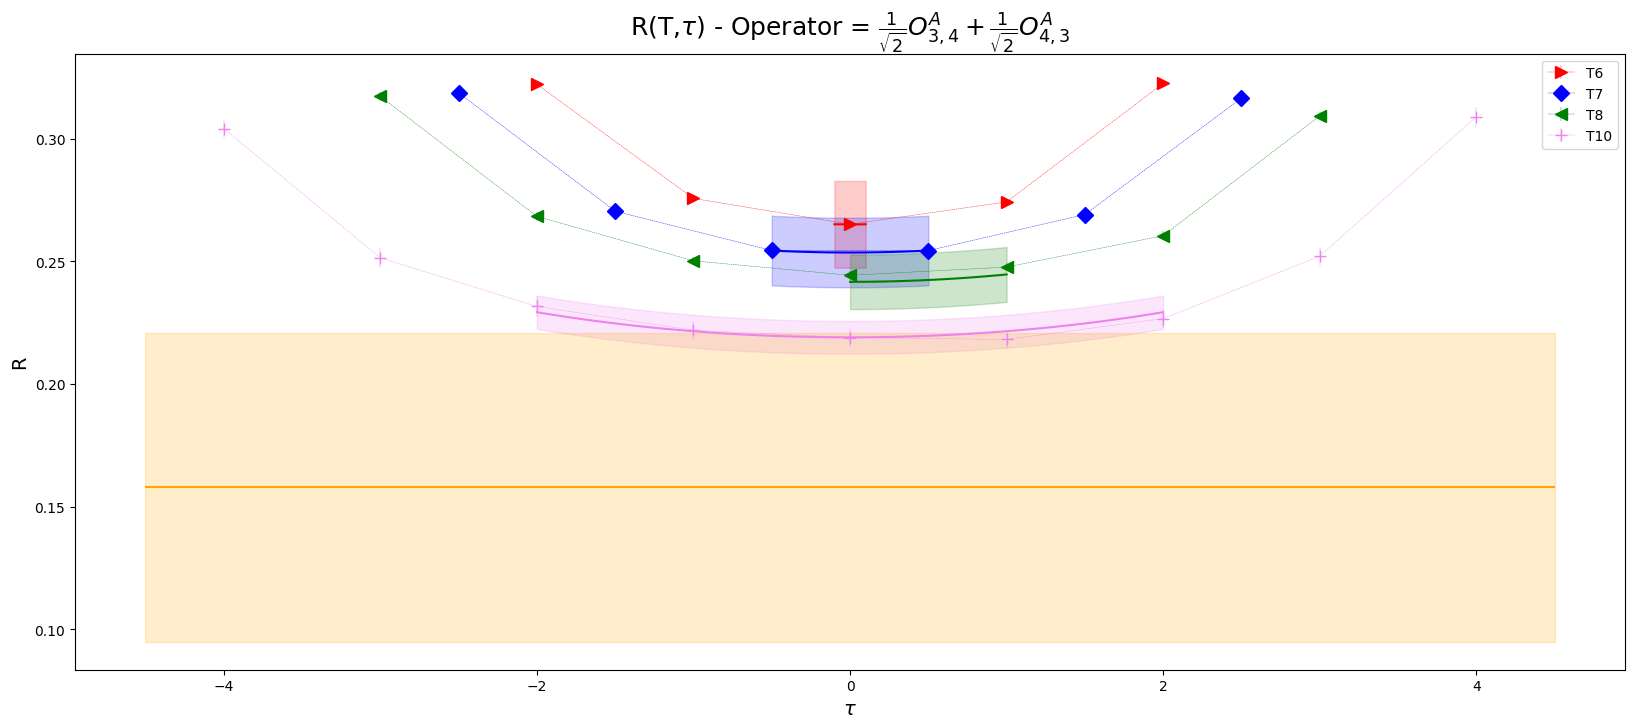

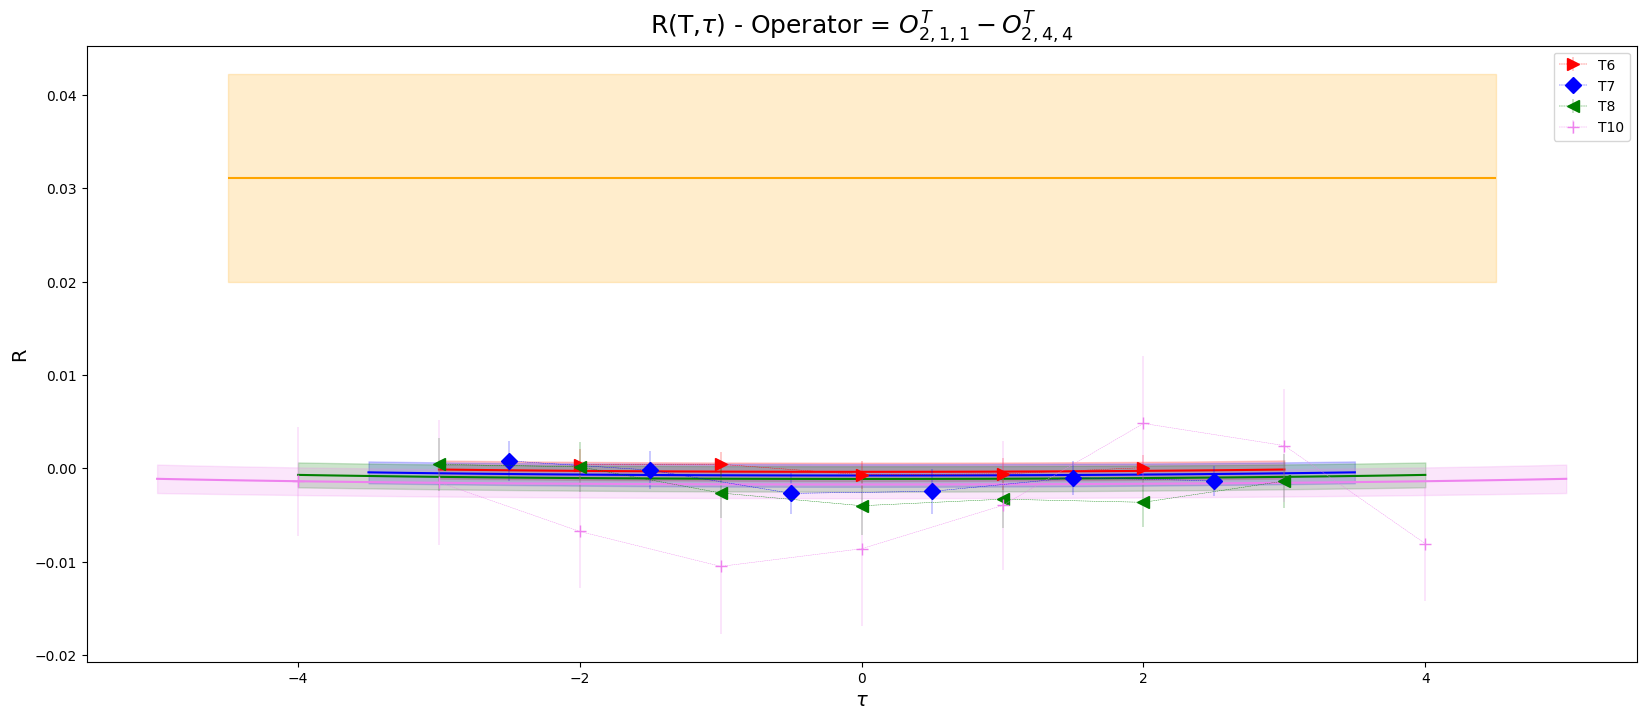

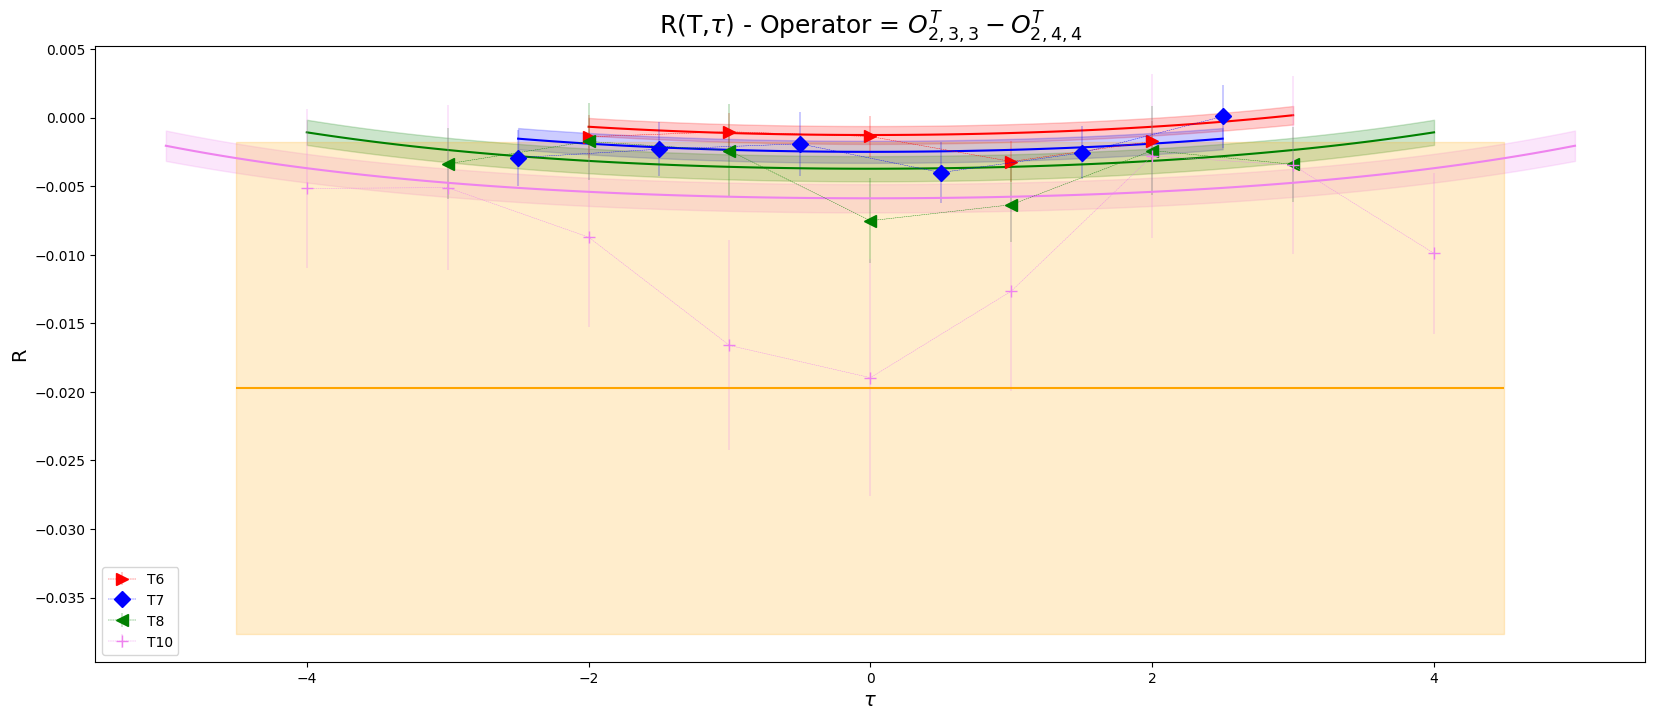

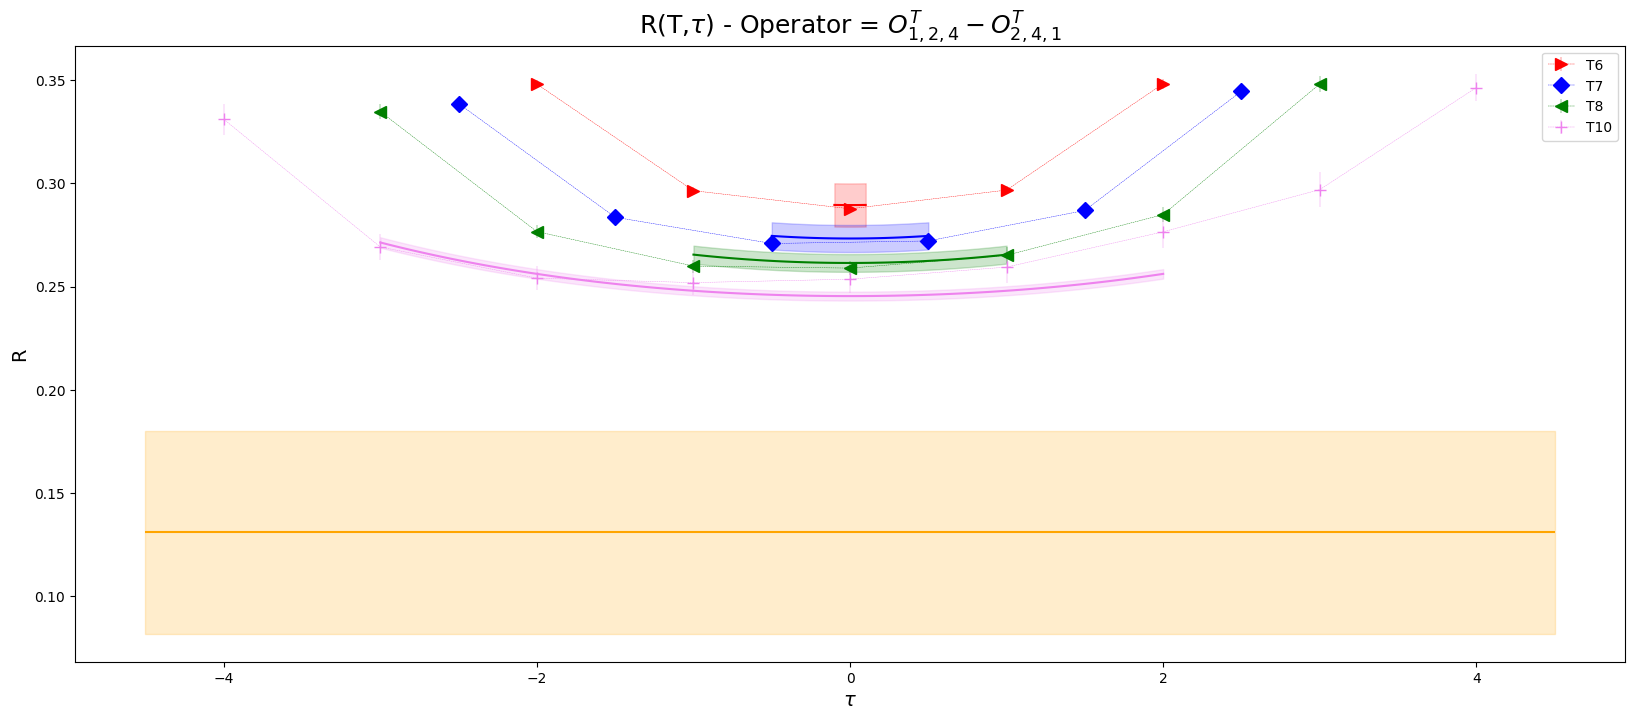

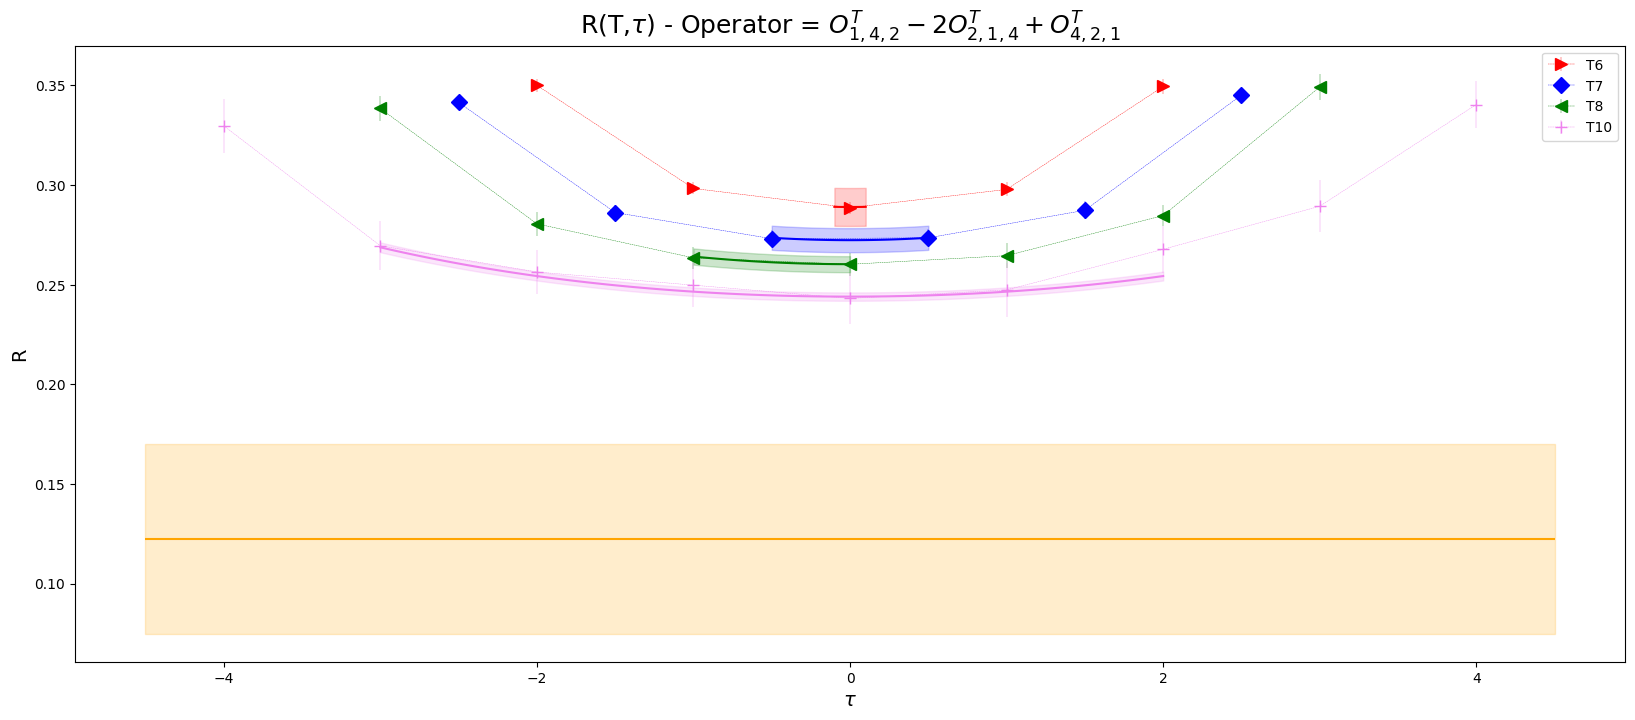

In [175]:
#we first fetch R using the dedicate method
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

#wewe instantiate the output list where we will store all the figure and axes
#fig_ax_list:list[tuple[Figure, Any]]  = []
#fig_ax_list = self.plot_R(show=False,save=True) #TO DO: adjust save - show condition in plot_R

figsize = (20,8)
fontsize_title =18
fontsize_x = 14
fontsize_y = 14
markersize = 8
rescale = True

colors = ['red','blue', 'green', 'violet', 'brown']

matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[2])

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):
    

    
    
    
    #fit avg results
    avg_result = fit_state_list[iop].model_average()
    dE = gv.gvar(avg_result["est"]['dE'], avg_result["err"]['dE'])
    matele = gv.gvar(avg_result["est"]['M'], avg_result["err"]['M'])
    R1 = gv.gvar(avg_result["est"]['R1'], avg_result["err"]['R1'])
    R2 = gv.gvar(avg_result["est"]['R2'], avg_result["err"]['R2'])
    R3 = gv.gvar(avg_result["est"]['R3'], avg_result["err"]['R3'])

    post_dict = {key:gv.gvar(avg_result["est"][key], avg_result["err"][key]) for key in avg_result["est"].keys()}

    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)

    #we add figure and axes to the output list
    #fig_ax_list.append((fig,ax))

    #we cycle on the markers
    marker = it.cycle(('>', 'D', '<', '+', 'o', 'v', 's', '*', '.', ',')) 

    #we loop over T and each time we add a graph to the plot
    for iT, T in enumerate(opAnalyzer.T_list):

        times = np.arange(-T/2+1,T/2)

        start_plateau, end_plateau = plateau_dict[(iop,iT)]
        #start_plateau, end_plateau

        #times = np.arange(1, T)

        #we grep the interesting part of the array and we ignore the padding along the last axis
        ratio = Rmean[iop,iT,1:T]
        ratio_err = Rstd[iop,iT,1:T]

        #we discard the endpoints
        r = ratio#[1:-1]
        r_err = ratio_err#[1:-1]

        #we rescale to the kfactor #TO DO: check the kinematics factors
        if rescale:
            #mass = opAnalyzer.get_meff()[0]
            #mass = opAnalyzer.fit_2pcorr(save=False,show=False).model_average()['est']['E0']
            a = 0.1163 #we cheat
            hc = 197.327
            mp_mev = 1000
            mass = mp_mev/hc * a
            #kin = 1j * op.evaluate_K(m_value=mass,E_value=mass,p1_value=0,p2_value=0,p3_value=0) #this 1j in front comes from the fact that mat_ele = <x> * i K
            #if np.iscomplex(kin):
            #    kin *= -1j
            #kin = kin.real
            kin = op.evaluate_K_real(m_value=mass,E_value=mass,p1_value=0,p2_value=0,p3_value=0)
            ratio /= kin if kin!=0 else 1
            #ratio /= np.abs( op.evaluate_K(m_value=mass,E_value=mass,p1_value=0,p2_value=0,p3_value=0) )


        #_=plt.plot(times,r,marker = 'o', linewidth = 0.3, linestyle='dashed',label=i)
        #ax.errorbar(times, r,yerr=ratio_err, marker = 'o', linewidth = 0.3, linestyle='dashed',label=f"T{T}")
        _ = ax.errorbar(times, r,yerr=r_err, marker = next(marker), markersize = markersize, linewidth = 0.3, linestyle='dashed',label=f"T{T}", color= colors[iT])
        _ = ax.legend()

        _ = ax.set_title(r"R(T,$\tau$) - Operator = ${}$".format(op),fontsize=fontsize_title)
        _ = ax.set_xlabel(r"$\tau$", fontsize=fontsize_x)
        _ = ax.set_ylabel('R', fontsize=fontsize_y)

        model = ratio_func_form(r1=True,r2=True,r3=True)

        eps = 0.1
        times = np.linspace(start_plateau, end_plateau-1,100) if end_plateau-start_plateau>1 else np.linspace(start_plateau-eps, end_plateau-1 + eps,100)
        times_plot = np.linspace(start_plateau-T/2, end_plateau-T/2-1,100) if end_plateau-start_plateau>1 else np.linspace(start_plateau-T/2-eps, end_plateau-T/2-1 + eps,100)
        x = times_plot
        y = np.asarray( [c.mean for c in  model( np.asarray( [(T,tau) for tau in times] ) ,post_dict)] )

        yps = np.asarray( [c.mean + c.sdev for c in  model( np.asarray( [(T,tau) for tau in times] ) ,post_dict)] )
        yms = np.asarray( [c.mean - c.sdev for c in  model( np.asarray( [(T,tau) for tau in times] ) ,post_dict)] )

        if rescale:
            y /=  kin if kin!=0 else 1
            yps /=  kin if kin!=0 else 1
            yms /=  kin if kin!=0 else 1

        _ = ax.plot(x,  y, color= colors[iT])
        _ = ax.fill_between(x,yms,yps, alpha = 0.2, color= colors[iT])


    mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] ) #/ kin
    #mat_ele_avg = matele_fromS[iop][2]

    T=11

    if rescale:
       mat_ele_avg /=  kin if kin!=0 else 1

    _ = ax.hlines(mat_ele_avg.mean, -T/2+1,T/2-1,linestyle="solid", color="orange")
    #ax.hlines(mat_ele_avg.mean + mat_ele_avg.std, -T/2+1,T/2,linestyle="solid", color="orange", alpha)
    #ax.hlines(mat_ele_avg.mean - mat_ele_avg.std,-T/2+1,T/2,linestyle="solid", color="orange")
    _ = ax.fill_between(np.arange(-T/2+1,T/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")


    plt.show()

# First moment esitamte

In [135]:
matele_list = []

for iop in range(opAnalyzer.Nop):
    avg_result = fit_state_list[iop].model_average()
    dE = gv.gvar(avg_result["est"]['dE'], avg_result["err"]['dE'])
    matele = gv.gvar(avg_result["est"]['M'], avg_result["err"]['M'])
    matele_list.append(matele)

matele_list

matele_list = np.asarray(matele_list)

[0.05158(31),
 0.06387(79),
 0.0066(28),
 -0.00386(17),
 -0.0663(13),
 -0.0026(16),
 -0.0097(11),
 0.12743(67),
 0.2512(13)]

In [104]:
fit2p_state = opAnalyzer.fit_2pcorr(save=False,show=False)

In [110]:
model_avg_2p = fit2p_state.model_average()

E0 = gv.gvar( model_avg_2p["est"]["E0"], model_avg_2p["err"]["E0"])

E0 *hc / a

927.5(1.6)

In [115]:
from sympy import lambdify

In [127]:
from kinematic_data import E, p1,p2,p3,mN, I

In [125]:
lambdify([E, mN, p1,p2,p3], 1j*op.K)(E0, E0, gv.gvar(0,0), gv.gvar(0,0), gv.gvar(0,0))

0.27331(48)

In [136]:
K_list = []

for iop,op in enumerate(opAnalyzer.selected_op):

    #kin = op.evaluate_K_real(E_value=E0, m_value=E0,
    #                       p1_value=0,p2_value=0,p3_value=0)

    kin = I * op.K

    if op.p3corr_is_real:
        kin *= -I

    kin = lambdify([E, mN, p1,p2,p3], 1j*kin)(E0, E0, gv.gvar(0,0), gv.gvar(0,0), gv.gvar(0,0))

    K_list.append(kin)

   
K_list


K_list = np.asarray( K_list)

[0.27331(48),
 0.38652(68),
 0 ± 0,
 0 ± 0,
 0.38652(68),
 0 ± 0,
 0 ± 0,
 0.54663(96),
 1.0933(19)]

In [140]:
moments = np.asarray( [matele / K for matele,K in zip(matele_list,K_list) if K!=0] )
moments

array([0.1887(12), 0.1653(21), -0.1715(33), 0.2331(13), 0.2298(12)],
      dtype=object)